In [1]:
import numpy as np

import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import pandas as pd
from pandas.plotting import register_matplotlib_converters
from pandas.api.types import CategoricalDtype

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

from mpl_toolkits.mplot3d import Axes3D

import pytz, datetime
from datetime import datetime, time, timedelta
from dateutil import tz

import seaborn as sns

#from zipfile import ZipFile
#from io import BytesIO
#from urllib.request import urlopen

import itertools
from itertools import *

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore');

%matplotlib inline
MergeListe = []

# Reading Weather Data

## Reading the weather data files and merging them into one Dataframe

### Important note: all datasets have to be stored in the same repository

1. Import the Data in Panda Dataframe
2. Rename columns
3. Choose relevant time frame
3. Put df into the MergeList

### Importing the air temperature data in °C

In [2]:
#Temperature file to be found under: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/stundenwerte_TU_01420_19810101_20181231_hist.zip
#importing only relevant columns
Temp_Dataset = pd.read_csv("Temperatur_tu_stunde_19810101_20181231_01420.txt", 
                header = 0,
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_9",
                        "Temperature",
                        "RelativeAirHumidity",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","Temperature","RelativeAirHumidity"])

#slicing only the relevant timeframe out of "DateTime"
Temp_Dataset = Temp_Dataset[Temp_Dataset["DateTime"] >= 2014123123]
Temp_Dataset = Temp_Dataset[Temp_Dataset["DateTime"] <2016123123]

#format the column "DateTime" and add it as a seperate column
Temp_Dataset["FormattedDate"]= pd.to_datetime(Temp_Dataset['DateTime'], format='%Y%m%d%H')

#Strip relevant date information out of date
Temp_Dataset["Month"] = Temp_Dataset["FormattedDate"].dt.strftime('%m') #Month as a number (zero padded)
Temp_Dataset["Weekday"] = Temp_Dataset["FormattedDate"].dt.strftime('%w') #Weekday as number (Monday = 0, Tuesday = 1, ...) 
Temp_Dataset["Hour"] = Temp_Dataset["FormattedDate"].dt.strftime('%H') #Hour as number (zero padded)
Temp_Dataset["Year"] = Temp_Dataset["FormattedDate"].dt.strftime('%Y') #Year

#using "DateTime" as the new index
Ind_Dataset = Temp_Dataset.set_index(["DateTime"])

#append the MergeListe with the indexed Dataframe
MergeListe.append(Ind_Dataset)

#print(Ind_Dataset)

### Importing the sunshine duration data in minutes per hour

In [3]:
#sunshine data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/sun/historical/stundenwerte_SD_01420_19510101_20181231_hist.zip
#importing only relevant columns, indexing

Sun_Dataset = pd.read_csv("sonne_sd_stunde_19510101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_7",
                        "SunshineDuration",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","SunshineDuration"])

#slicing only the relevant timeframe out of "DateTime"
Sun_Dataset = Sun_Dataset[Sun_Dataset.index>= 2014123123]
Sun_Dataset = Sun_Dataset[Sun_Dataset.index <2016123123]

#print(Sun_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Sun_Dataset)

### Importing the total cloud cover data per hour
#### Cloudiness ranked from 0 to 8; -1 for the case that they sky is not visible

In [4]:
#cloud data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/cloudiness/historical/stundenwerte_N_01420_19490101_20181231_hist.zip
#importing only relevant columns, indexing
Cloud_Dataset = pd.read_csv("Cloudiness_n_stunde_19490101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_8",
                        "IndexHowMeasurementIsTaken",
                        "TotalCloudCover",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","TotalCloudCover"])

#slicing only the relevant timeframe out of "DateTime"
Cloud_Dataset = Cloud_Dataset[Cloud_Dataset.index>= 2014123123]
Cloud_Dataset = Cloud_Dataset[Cloud_Dataset.index <2016123123]

#print(Cloud_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Cloud_Dataset)

### Importing the precipitation data in mm per hour

In [5]:
#Precipitation data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/stundenwerte_RR_01420_19950901_20181231_hist.zip
#importing only relevant columns, indexing
Precipitation_Dataset = pd.read_csv("Niederschlag_rr_stunde_19950901_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_8",
                        "PrecipitationHeight",
                        "PrecipitationBool",
                        "FormOfPrecipitation",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","PrecipitationHeight"])

#slicing only the relevant timeframe out of "DateTime"
Precipitation_Dataset = Precipitation_Dataset[Precipitation_Dataset.index>= 2014123123]
Precipitation_Dataset = Precipitation_Dataset[Precipitation_Dataset.index <2016123123]

#print(Precipitation_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Precipitation_Dataset)

### Importing the visibility data in meters

In [6]:
#ns visibility data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/visibility/historical/stundenwerte_VV_01420_19490101_20181231_hist.zip
#importing only relevant columns, indexing
Visibility_Dataset = pd.read_csv("Sicht_vv_stunde_19490101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_8",
                        "IndexHowMeasurementIsTaken",
                        "Visibility",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","Visibility"])
#slicing only the relevant timeframe out of "DateTime"

Visibility_Dataset = Visibility_Dataset[Visibility_Dataset.index>= 2014123123]
Visibility_Dataset = Visibility_Dataset[Visibility_Dataset.index <2016123123]

#print(Visibility_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Visibility_Dataset)

### Importing the wind speed data in meters per second

In [7]:
#wind data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/wind/historical/stundenwerte_FF_01420_19670101_20181231_hist.zip
#importing only relevant columns, indexing
Wind_Dataset = pd.read_csv("Wind_ff_stunde_19670101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_3",
                        "MeanWindSpeed",
                        "MeanWindDirection",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","MeanWindSpeed"])

#slicing only the relevant timeframe out of "DateTime"
Wind_Dataset = Wind_Dataset[Wind_Dataset.index>= 2014123123]
Wind_Dataset = Wind_Dataset[Wind_Dataset.index <2016123123]

#print(Wind_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Wind_Dataset)

## Joining all existing Dataframes (in the MergeListe) by using the indices


In [8]:
#merging the df in the list by using pd.concat
Wetterdaten = pd.concat(MergeListe, axis=1)

Wetterdaten['FormattedDate'].dt.strftime('%Y-%m-%d %X')

#print (Wetterdaten)
Wetterdaten.describe()

,Temperature,RelativeAirHumidity,SunshineDuration,TotalCloudCover,PrecipitationHeight,Visibility,MeanWindSpeed
count,17544.000000,17544.000000,13158.000000,17544.000000,17536.000000,17544.000000,17544.000000
mean,11.376482,74.607273,14.988524,5.371295,-0.565174,33744.219676,3.404195
std,7.857234,19.438891,22.842231,2.622536,25.018618,18481.061803,2.121886
min,-7.200000,16.000000,0.000000,-1.000000,-999.000000,100.000000,0.000000
25%,5.100000,61.000000,0.000000,3.000000,0.000000,18000.000000,1.800000
50%,10.800000,78.000000,0.000000,7.000000,0.000000,35000.000000,2.900000
75%,16.900000,92.000000,28.000000,7.000000,0.000000,50000.000000,4.500000
max,38.100000,100.000000,60.000000,8.000000,19.100000,81900.000000,18.800000


## Cleaning the data and handling error values
### Assigning numerical error values to 'nan' so that statistical methods are not biased

1. Checking the error values of each data set
<ul>
<li>Temperature Error values are -999</li>
<li>Relative Air humidity error values are -999</li>
<li>Sunshine duration error values are -999</li>
<li>Totalcloudcover error values are -999</li>
<li>Precipitationheight error values are -999</li>
<li>Visibility error values are -999</li>
<li>Meanwindspeed error values are non existent</li>
</ul>


2. All -999 in the dataframe are replaced by NaN
<ul>
<li>Only PrecipitationHeight has error values</li>
<li>Create new dataframe to keep original active and have the new one anyway</li>

In [9]:
Wetterdaten_nand = Wetterdaten.replace(-999,np.NaN)

#Option to overwrite dataframe or not
Wetterdaten = Wetterdaten_nand


In [10]:
Wetterdaten.describe()

,Temperature,RelativeAirHumidity,SunshineDuration,TotalCloudCover,PrecipitationHeight,Visibility,MeanWindSpeed
count,17544.000000,17544.000000,13158.000000,17544.000000,17525.000000,17544.000000,17544.000000
mean,11.376482,74.607273,14.988524,5.371295,0.061518,33744.219676,3.404195
std,7.857234,19.438891,22.842231,2.622536,0.429199,18481.061803,2.121886
min,-7.200000,16.000000,0.000000,-1.000000,0.000000,100.000000,0.000000
25%,5.100000,61.000000,0.000000,3.000000,0.000000,18000.000000,1.800000
50%,10.800000,78.000000,0.000000,7.000000,0.000000,35000.000000,2.900000
75%,16.900000,92.000000,28.000000,7.000000,0.000000,50000.000000,4.500000
max,38.100000,100.000000,60.000000,8.000000,19.100000,81900.000000,18.800000


### Handling missing data
1. Description above shows, that only sunshine and precipitation values are missing. Precipitation is only missing 19 values, <br> these will be filled via forward fill, because the missing values are < 0.2% and we assume some weather stability, rather <br> than to assume 0 or mean values. <br> <br>

2. SunshineDuration is always missing 6h from 9 pm until 3 am. Will be imputed with zeros, because the sun typically does not <br> shine at night in Frankfurt.


In [11]:
#Fill precipitation data
Wetterdaten['PrecipitationHeight'].fillna(method='ffill', inplace=True)

#Fill sunshine data
Wetterdaten['SunshineDuration'].fillna(0, inplace=True)

Wetterdaten.describe()
Wetterdaten.iloc[1224:1260]
Wetterdaten.iloc[9000:9049]

,Temperature,RelativeAirHumidity,FormattedDate,Month,Weekday,Hour,Year,SunshineDuration,TotalCloudCover,PrecipitationHeight,Visibility,MeanWindSpeed
DateTime,,,,,,,,,,,,
2016011023,5.4,93.0,2016-01-10 23:00:00,01,0,23,2016,0.0,7,0.0,30000,3.0
2016011100,5.5,95.0,2016-01-11 00:00:00,01,1,00,2016,0.0,7,0.0,30000,2.7
2016011101,5.7,94.0,2016-01-11 01:00:00,01,1,01,2016,0.0,7,0.0,30000,2.9
2016011102,5.7,91.0,2016-01-11 02:00:00,01,1,02,2016,0.0,6,0.0,30000,3.4
2016011103,4.4,93.0,2016-01-11 03:00:00,01,1,03,2016,0.0,5,0.0,40000,3.4
2016011104,3.8,96.0,2016-01-11 04:00:00,01,1,04,2016,0.0,7,0.0,40000,1.6
2016011105,3.1,97.0,2016-01-11 05:00:00,01,1,05,2016,0.0,7,0.0,30000,1.1
2016011106,3.8,97.0,2016-01-11 06:00:00,01,1,06,2016,0.0,7,0.0,30000,1.6
2016011107,4.3,96.0,2016-01-11 07:00:00,01,1,07,2016,0.0,7,0.0,40000,2.3


## Choose Formatted Column as new Index

In [12]:
Ind_Wetterdaten = Wetterdaten.set_index(['FormattedDate'])

#Ind_Wetterdaten.head()

## Save Dataset in csv in order to allow fast access

In [13]:
Ind_Wetterdaten.to_csv("Datenbasis_Weather_beforePlotting.csv")

# Plotting Weather Data
## Data visualization for data understanding purposes
### Temperature during the two year period

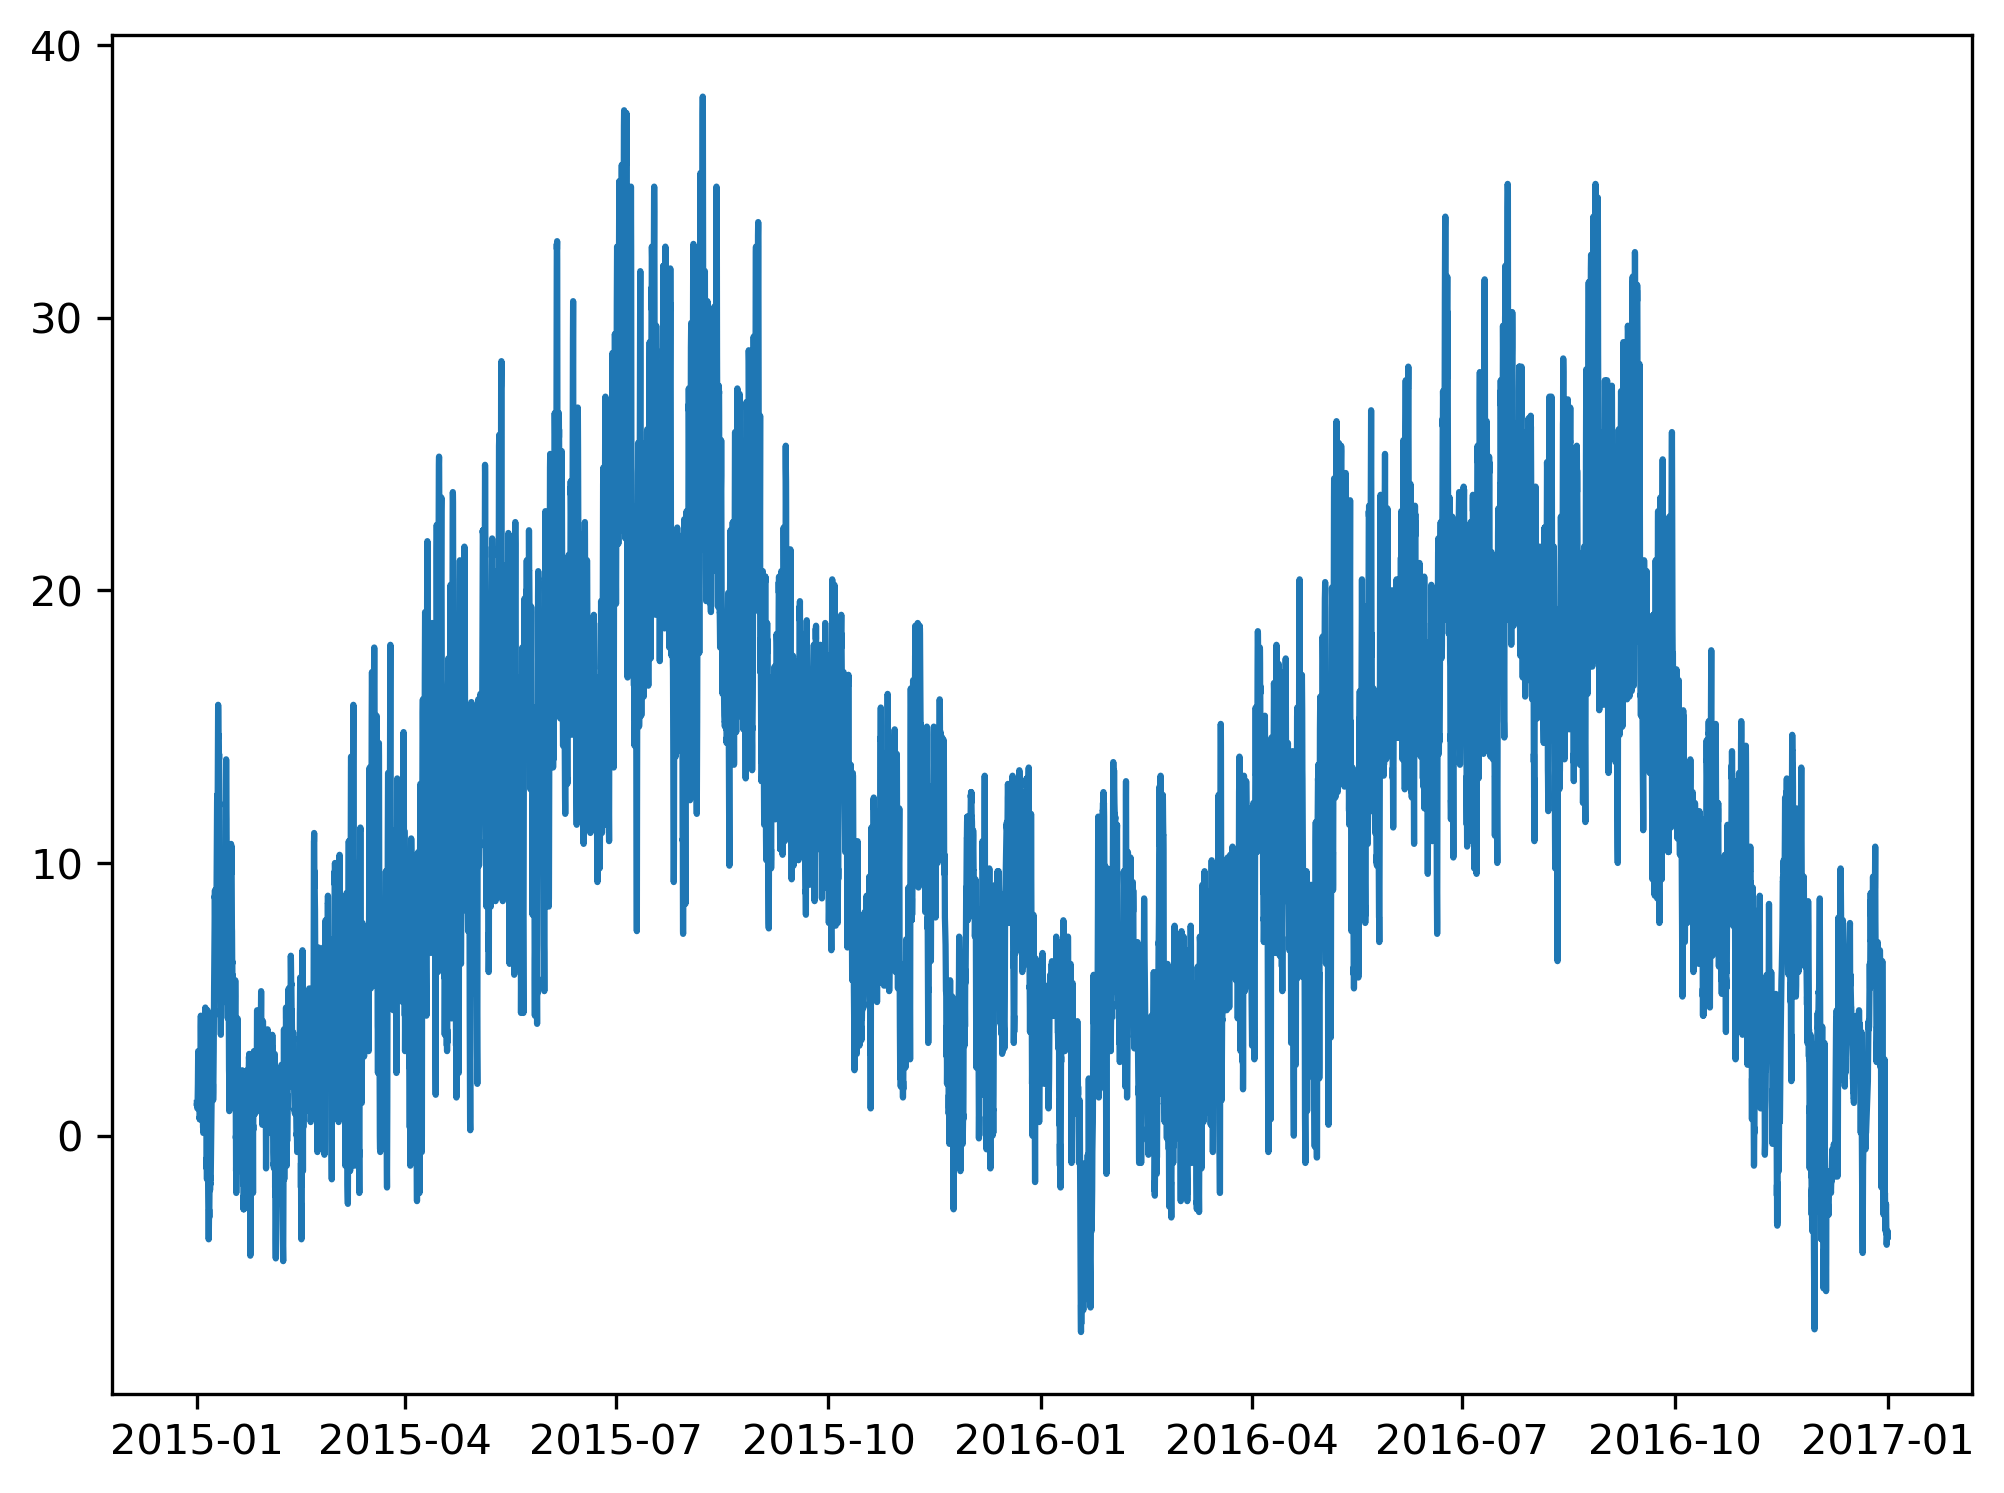

In [14]:
Fig_1 = plt.figure(figsize=(8,6),dpi = 300)
plt.plot(Ind_Wetterdaten.index,Ind_Wetterdaten['Temperature'])
plt.show()

### Development of the temperature on two random days

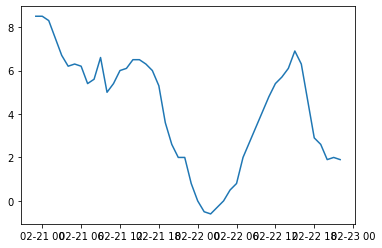

In [15]:
plt.plot(Ind_Wetterdaten.index[1224:1272],Ind_Wetterdaten['Temperature'][1224:1272])
plt.show()

### Development of the precipitation on two random days

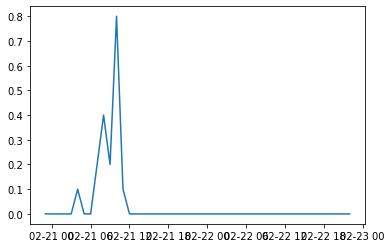

In [16]:
plt.plot(Ind_Wetterdaten.index[1224:1272],Ind_Wetterdaten['PrecipitationHeight'][1224:1272])
plt.show()

### Histogramm of the temperature

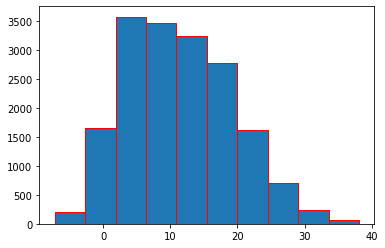

In [17]:
plt.hist(Ind_Wetterdaten['Temperature'], bins=10, edgecolor='red')
plt.show()

# Using the Pearson Correlation
### Let's have a look at the correlation between the variables 

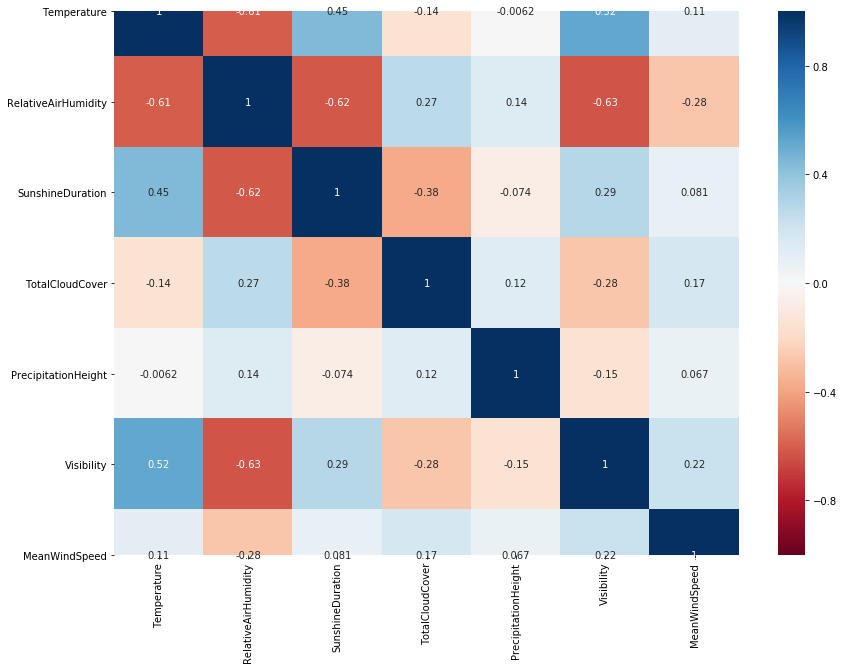

In [18]:
plt.figure(figsize=(14,10))
cor = Ind_Wetterdaten.corr()

sns.heatmap(cor,vmin=-1, vmax=1, annot=True, cmap="RdBu")
plt.show()

## Creating a new dataframe with only the relevant columns and all rows for now

Due to a high correlation (>0.2) with Temperature and other variables we decided to put out SunshineDuration, Visibility as well as Relative Air Humidity. This enables us to foucs on the future feature target (bike rental demand) and provides us variables that are independet from each other. This makes all our futue models more precise. 

In [19]:
Rel_Wetterdaten = Ind_Wetterdaten.loc[:, ['Temperature','TotalCloudCover', 'PrecipitationHeight','MeanWindSpeed','Month','Weekday','Hour',"Year"]]

Rel_Wetterdaten.head()

#exporting new data as csv
Rel_Wetterdaten.to_csv("Datenbasis_Weather_relevant.csv")

# Reading Bike Data

## Adding the amount of rented bikes per hour to the weather data set

### Reading the csv file and  choosing only relevant data (Frankfurt and Dates 2015 - 2016)

In [20]:
#reading csv file

booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", 
                delimiter=';')

#only using the entries that include "Frankfurt"
booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]

#only using the column DATE_BOOKING
booking_set_frankfurt = booking_set_frankfurt.loc[:,['DATE_BOOKING','START_RENTAL_ZONE']]

#drop all rows that have empty values (NaN values)
booking_set_frankfurt = booking_set_frankfurt.dropna(axis=0)

#sort the data after the date, ascending
booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True)

#format the column to datetime
booking_set_frankfurt['DATE_BOOKING']= pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'], format='%Y-%m-%d %H')

#only use relevant time frame
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]
booking_set_frankfurt_20152016

print (booking_set_frankfurt_20152016)


                DATE_BOOKING                     START_RENTAL_ZONE
4284612  2015-01-01 00:21:22    Speyerer Straße / Koblenzer Straße
4285336  2015-01-01 00:30:20          Roßmarkt / An der Hauptwache
4285873  2015-01-01 00:42:51           Woolworth Leipziger Strasse
4286542  2015-01-01 01:00:19                    Markus-Krankenhaus
4286567  2015-01-01 01:00:47                    Markus-Krankenhaus
...                      ...                                   ...
14613160 2016-12-31 23:13:00  Hauptbahnhof Haupteingang (Vorplatz)
14613511 2016-12-31 23:23:28           Taunusstraße / Gallusanlage
14612056 2016-12-31 23:24:03                Sternstraße / Unterweg
14615815 2016-12-31 23:28:04                Sternstraße / Unterweg
14612244 2016-12-31 23:40:33         Krifteler Straße / Lahnstraße

[1222018 rows x 2 columns]


### Changing the time from CET/CEST to UTC using tz_localize and tz_convert 


In [21]:
#Use the column "DATE_BOOKING" as Index
Ind_Bookings = booking_set_frankfurt_20152016.set_index(['DATE_BOOKING'])
#print (Ind_Bookings)

#convert to UTC 
Ind_Bookings_UTC = Ind_Bookings.tz_localize(('Europe/Berlin'),ambiguous = "NaT").tz_convert(pytz.utc)
#print (Ind_Bookings_UTC)

#drop "localize", so lenth of index can match to weather Data
Ind_Bookings_UTC= Ind_Bookings_UTC.tz_localize(None)
#print(Ind_Bookings_UTC)


## Removing the minutes of the time stamp by using the .floor function

In [22]:
Ind_Bookings_UTC.index = pd.to_datetime(Ind_Bookings_UTC.index).floor('h')

#second dataframe for different aggregation
Ind_Bookings_Stations_UTC = Ind_Bookings_UTC

#following code is necessary to recreate the empty dataframe without the station and with only the datetimes as index
lst = []
lst = Ind_Bookings_UTC.index
Ind_Bookings_UTC_new = pd.DataFrame(lst)
Ind_Bookings_UTC_new = Ind_Bookings_UTC_new.set_index(['DATE_BOOKING'])
Ind_Bookings_UTC = Ind_Bookings_UTC_new

#print (Ind_Bookings_UTC)

### Group the Dataframe by its Date (Hour of Booking) to generate a column counting the amount of rentals per hour

In [23]:
Ind_Bookings_UTC['Rentals'] =Ind_Bookings_UTC.groupby('DATE_BOOKING').size()
Ind_Bookings_UTC.groupby('DATE_BOOKING')
#print (Ind_Bookings_UTC)

In [24]:
Ind_Bookings_Stations_UTC["zeitspalte"] = Ind_Bookings_Stations_UTC.index

Ind_Bookings_Stations_UTC['Rentals'] = 1

ser23 = Ind_Bookings_Stations_UTC.groupby(['zeitspalte','START_RENTAL_ZONE'])['Rentals'].sum()

Ind_Bookings_Stations_UTC_new = pd.DataFrame(ser23)
check = Ind_Bookings_Stations_UTC_new.reset_index(inplace=True)
check

Ind_Bookings_Stations_UTC_new = Ind_Bookings_Stations_UTC_new.rename(columns={"zeitspalte": "DATE_BOOKING"})

Ind_Bookings_Stations_UTC_new = Ind_Bookings_Stations_UTC_new.set_index(['DATE_BOOKING'])

Ind_Bookings_Stations_UTC = Ind_Bookings_Stations_UTC_new



### Join the weather and bike data and drop the duplicates

In [25]:
#create a zeitspalte to help identify duplicate rows
Ind_Bookings_UTC["zeitspalte"] = Ind_Bookings_UTC.index
Ind_Bookings_UTC.drop_duplicates(keep = "first", inplace = True)
#print(Ind_Bookings_UTC)

In [26]:
Datenbasis = Rel_Wetterdaten.join(Ind_Bookings_UTC)
Datenbasis = Datenbasis.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour","Year", "Rentals"]]

Datenbasis.describe()

#impute nan values for rentals as 0, because there are no bookings in this hour
Datenbasis['Rentals'].fillna(0, inplace=True)

Datenbasis['Month'] = Datenbasis['Month'].astype(int)
Datenbasis['Weekday'] = Datenbasis['Weekday'].astype(int)
Datenbasis['Hour'] = Datenbasis['Hour'].astype(int)
Datenbasis['Year'] = Datenbasis['Year'].astype(int)

Datenbasis.to_csv("DataBase_WeatherRentalAmount_UTC.csv")


Datenbasis2 = Rel_Wetterdaten.join(Ind_Bookings_UTC)
Datenbasis2 = Datenbasis2.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour","Year", "Rentals"]]
Datenbasis2['Rentals'].fillna(0, inplace=True)
                              
Datenbasis6 = Rel_Wetterdaten.join(Ind_Bookings_UTC)
Datenbasis6 = Datenbasis6.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour","Year", "Rentals"]]
Datenbasis6['Rentals'].fillna(0, inplace=True)
                             
Datenbasis24 = Rel_Wetterdaten.join(Ind_Bookings_UTC)
Datenbasis24 = Datenbasis24.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour","Year", "Rentals"]]
Datenbasis24['Rentals'].fillna(0, inplace=True)
                             
#formatting the strings into integer

Datenbasis2['Month'] = Datenbasis2['Month'].astype(int)
Datenbasis2['Weekday'] = Datenbasis2['Weekday'].astype(int)
Datenbasis2['Hour'] = Datenbasis2['Hour'].astype(int)
Datenbasis2['Year'] = Datenbasis2['Year'].astype(int)
                               
Datenbasis6['Month'] = Datenbasis6['Month'].astype(int)
Datenbasis6['Weekday'] = Datenbasis6['Weekday'].astype(int)
Datenbasis6['Hour'] = Datenbasis6['Hour'].astype(int)
Datenbasis6['Year'] = Datenbasis6['Year'].astype(int)

Datenbasis24['Month'] = Datenbasis24['Month'].astype(int)
Datenbasis24['Weekday'] = Datenbasis24['Weekday'].astype(int)
Datenbasis24['Hour'] = Datenbasis24['Hour'].astype(int)
Datenbasis24['Year'] = Datenbasis24['Year'].astype(int)

In [27]:
Datenbasis_Stations = Ind_Bookings_Stations_UTC.join(Rel_Wetterdaten)
Datenbasis_Stations = Datenbasis_Stations.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour", "Year", "START_RENTAL_ZONE", "Rentals"]]

Datenbasis_Stations.describe()

#print(Datenbasis_Stations)

Datenbasis_Stations.to_csv("DataBase_WeatherRentalAmountStations_UTC.csv")

In [28]:
#Three identical dataframes to group them with groupby

In [29]:
N = len(Datenbasis.index) 
R = int(N/2)
Datenbasis2['grp'] = list(itertools.chain.from_iterable([x]*2 for x in range(0, R)))
#alt
#Datenbasis2 = Datenbasis2.groupby('grp').mean()
#neu
Datenbasis2b = Datenbasis2.groupby('grp').sum()
Datenbasis2 = Datenbasis2.groupby('grp').median()
#alt
#Datenbasis2['PrecipitationHeight'] = Datenbasis2['PrecipitationHeight'] * 2
#Datenbasis2['Rentals'] = Datenbasis2['Rentals'] * 2
#neu
Datenbasis2['Rentals'] = Datenbasis2b['Rentals']
Datenbasis2['PrecipitationHeight'] = Datenbasis2b['PrecipitationHeight']

Datenbasis2.drop(columns=['Hour'], inplace=True)
Datenbasis2.fillna(0, inplace=True)
Datenbasis2.to_csv("DataBase_WeatherRentalAmount_2h_UTC.csv")


In [30]:
Datenbasis2.describe()
Datenbasis2.head()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Year,Rentals
grp,,,,,,,,
0,1.20,8.0,0.0,1.70,6.5,3.5,2014.5,12.0
1,1.15,3.5,0.0,1.25,1.0,4.0,2015.0,34.0
2,1.10,-1.0,0.0,0.90,1.0,4.0,2015.0,23.0
3,1.00,7.5,0.0,1.30,1.0,4.0,2015.0,12.0
4,1.20,2.5,0.0,1.65,1.0,4.0,2015.0,4.0


In [31]:
R = int(N/6)

Datenbasis6['grp'] = list(itertools.chain.from_iterable([x]*6 for x in range(0, R)))
#alt
#Datenbasis6 = Datenbasis6.groupby('grp').mean()
#neu
Datenbasis6b = Datenbasis6.groupby('grp').sum()
Datenbasis6 = Datenbasis6.groupby('grp').median()
#alt
#Datenbasis6['PrecipitationHeight'] = Datenbasis6['PrecipitationHeight'] * 6
#Datenbasis6['Rentals'] = Datenbasis6['Rentals'] * 6
#neu
Datenbasis6['Rentals'] = Datenbasis6b['Rentals']
Datenbasis6['PrecipitationHeight'] = Datenbasis6b['PrecipitationHeight']
Datenbasis6.drop(columns=['Hour'], inplace=True)
Datenbasis6.fillna(0, inplace=True)
Datenbasis6.to_csv("DataBase_WeatherRentalAmount_6h_UTC.csv")


In [32]:
Datenbasis6.describe()
Datenbasis6.head()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Year,Rentals
grp,,,,,,,,
0,1.15,3.5,0.0,1.25,1.0,4.0,2015.0,69.0
1,1.20,6.5,0.0,1.65,1.0,4.0,2015.0,24.0
2,2.90,8.0,0.0,2.60,1.0,4.0,2015.0,38.0
3,2.60,8.0,0.0,4.15,1.0,4.0,2015.0,36.0
4,1.50,7.5,0.0,6.40,1.0,5.0,2015.0,11.0


In [33]:
R = int(N/24)

Datenbasis24['grp'] = list(itertools.chain.from_iterable([x]*24 for x in range(0, R)))
Datenbasis24.head
#alt
#Datenbasis24 = Datenbasis24.groupby('grp').mean()
#neu
Datenbasis24b = Datenbasis24.groupby('grp').sum()
Datenbasis24 = Datenbasis24.groupby('grp').median()
#alt
#Datenbasis24['PrecipitationHeight'] = Datenbasis24['PrecipitationHeight'] * 24
#Datenbasis24['Rentals'] = Datenbasis24['Rentals'] * 24
#neu
Datenbasis24['Rentals'] = Datenbasis24b['Rentals']
Datenbasis24['PrecipitationHeight'] = Datenbasis24b['PrecipitationHeight']

Datenbasis24.drop(columns=['Hour'], inplace=True)
Datenbasis24.fillna(0, inplace=True)
Datenbasis24.to_csv("DataBase_WeatherRentalAmount_24h_UTC.csv")
Datenbasis24.head

<bound method NDFrame.head of      Temperature  TotalCloudCover  PrecipitationHeight  MeanWindSpeed  Month  \
grp                                                                            
0           2.05              8.0                  0.0           2.30    1.0   
1           1.90              7.0                  6.4           6.70    1.0   
2           1.35              8.0                 11.4           3.10    1.0   
3           3.15              7.0                  0.2           4.55    1.0   
4           0.10              2.0                  0.0           2.65    1.0   
..           ...              ...                  ...            ...    ...   
726         5.50              7.0                  0.0           4.85   12.0   
727         4.75              7.0                  0.0           2.20   12.0   
728         1.15              0.5                  0.0           2.05   12.0   
729        -2.10              0.0                  0.0           2.15   12.0   
730       

In [34]:
Datenbasis24.describe()
Datenbasis24.head()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Year,Rentals
grp,,,,,,,,
0,2.05,8.0,0.0,2.30,1.0,4.0,2015.0,167.0
1,1.90,7.0,6.4,6.70,1.0,5.0,2015.0,243.0
2,1.35,8.0,11.4,3.10,1.0,6.0,2015.0,141.0
3,3.15,7.0,0.2,4.55,1.0,0.0,2015.0,251.0
4,0.10,2.0,0.0,2.65,1.0,1.0,2015.0,669.0


# Descriptive Analysis

## Data preperation

In [35]:
#reading the csv table in as data frame with panda
#if you have the problem that you cannot load this data, try to update your conda version and packages

#booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", delimiter=';')

In [36]:
booking_set.isna().sum()

BOOKING_HAL_ID                     0
CATEGORY_HAL_ID                    0
VEHICLE_HAL_ID                     0
CUSTOMER_HAL_ID                    0
DATE_BOOKING                       0
DATE_FROM                          0
DATE_UNTIL                         0
COMPUTE_EXTRA_BOOKING_FEE          0
TRAVERSE_USE                       0
DISTANCE                         514
START_RENTAL_ZONE            3394198
START_RENTAL_ZONE_HAL_ID      669310
END_RENTAL_ZONE              3439870
END_RENTAL_ZONE_HAL_ID        697042
RENTAL_ZONE_HAL_SRC           224902
CITY_RENTAL_ZONE                   0
TECHNICAL_INCOME_CHANNEL      223469
dtype: int64

In [37]:
#do not remove the NaN before actually doing something with the stations

In [38]:
booking_set.columns
#show the column names of the csv data. Remark: the file from 2017 has a lot less columns than the file from 2016
#but the 2017 file contains the time interval we were assigned

Index(['BOOKING_HAL_ID', 'CATEGORY_HAL_ID', 'VEHICLE_HAL_ID',
       'CUSTOMER_HAL_ID', 'DATE_BOOKING', 'DATE_FROM', 'DATE_UNTIL',
       'COMPUTE_EXTRA_BOOKING_FEE', 'TRAVERSE_USE', 'DISTANCE',
       'START_RENTAL_ZONE', 'START_RENTAL_ZONE_HAL_ID', 'END_RENTAL_ZONE',
       'END_RENTAL_ZONE_HAL_ID', 'RENTAL_ZONE_HAL_SRC', 'CITY_RENTAL_ZONE',
       'TECHNICAL_INCOME_CHANNEL'],
      dtype='object')

In [39]:
#get the data just Frankfurt
booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]
booking_set_frankfurt

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
11,21366889,50000,106071,9C652AE093696A00AE03CE808E41FEB8207586E3,2014-01-01 00:46:33,2014-01-01 00:46:33,2014-01-01 00:54:20,Nein,Nein,0.0,Ostbahnhof,227447.0,NaN,NaN,Standort,Frankfurt am Main,iPhone CAB
17,21367245,50000,108136,52F601C735727653A8113E8AD5AC52E3BF89B492,2014-01-01 02:34:11,2014-01-01 02:34:11,2014-01-01 02:55:57,Nein,Nein,0.0,Carlo-Schmidt-Platz / Depot,214448.0,Rosa-Luxemburg-Straße / Ginnheimer Landstraße,231648.0,Standort,Frankfurt am Main,IVR
26,21367472,50000,109066,849E39869B95293B7F0DF50F3F4CC95ED129ED52,2014-01-01 03:27:52,2014-01-01 03:27:52,2014-01-01 03:31:29,Nein,Nein,0.0,Roßmarkt / An der Hauptwache,214380.0,NaN,NaN,Standort,Frankfurt am Main,Android CAB
30,21368072,50000,116406,D7EB6708429AFFCAC213B716FF7BA2C0D1FFCAAE,2014-01-01 07:01:31,2014-01-01 07:01:31,2014-01-01 07:07:57,Nein,Nein,0.0,Bettinaplatz / Bettinastraße,214394.0,NaN,NaN,Standort,Frankfurt am Main,IVR
31,21368145,50000,116338,58429BD51BD30BA6D2B41CCBA3E3EE733DE9D07B,2014-01-01 08:02:11,2014-01-01 08:02:11,2014-01-01 08:13:56,Nein,Nein,0.0,Hauptbahnhof Haupteingang (Vorplatz),214419.0,NaN,NaN,Standort,Frankfurt am Main,Android CAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16228278,46382177,50000,163499,902CF8DEF6AA158418C036CCE6717D7551E671A3,2017-05-15 22:29:05,2017-05-15 22:29:05,2017-05-15 22:34:12,Ja,Nein,0.0,NaN,NaN,Studentenwohnheim Ginnheimer Landstr. 42,226257.0,Standort,Frankfurt am Main,IVR
16228279,46382184,50000,164121,A799BA8BA9892CBFF1CAA0C8481FAF49C27D2062,2017-05-15 22:29:25,2017-05-15 22:29:25,2017-05-15 22:43:06,Ja,Nein,0.0,Wendelsplatz / Darmstädter Landstraße,254302.0,Wittelsbacher Allee/ Habsburger Allee,227464.0,Standort,Frankfurt am Main,iPhone CAB
16228285,46382655,50000,165782,D940F501E7B61380A54B2AA0AD8DC7D6757237EF,2017-05-15 22:59:04,2017-05-15 22:59:04,2017-05-15 23:13:56,Ja,Nein,0.0,Roßmarkt / An der Hauptwache,214380.0,Arnsburger Straße / Mainkurstraße,227475.0,Standort,Frankfurt am Main,Android CAB
16228287,46383071,50000,164539,3D6E9CE1A4A554AF82B92020BCFAF4B6AC886446,2017-05-15 23:30:24,2017-05-15 23:30:24,2017-05-15 23:39:53,Ja,Nein,0.0,Bockenheimer Landstraße / Liebigstraße,31166.0,Kaufunger Straße / Kleine Seestraße,28835.0,Standort,Frankfurt am Main,iPhone CAB


In [40]:
#just get the two columns and convert date column to new time format
booking_set_frankfurt = booking_set_frankfurt.loc[:,['BOOKING_HAL_ID', 'DATE_BOOKING']]
booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True) #sort the data after the date, ascending
booking_set_frankfurt['DATE_BOOKING'] = pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'])
booking_set_frankfurt['DATE_BOOKING'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt

,BOOKING_HAL_ID,DATE_BOOKING
281,21366826,2014-01-01 00:30:23
302,21366878,2014-01-01 00:44:05
509,21366882,2014-01-01 00:45:02
67,21366884,2014-01-01 00:45:32
11,21366889,2014-01-01 00:46:33
...,...,...
16227888,46386849,2017-05-16 08:13:05
16228266,46386851,2017-05-16 08:13:08
16227184,46386855,2017-05-16 08:13:17
16227537,46386859,2017-05-16 08:13:29


In [41]:
# set start date and beginning date: change date format if needed
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]
booking_set_frankfurt_20152016

,BOOKING_HAL_ID,DATE_BOOKING
4284612,27689006,2015-01-01 00:21:22
4285336,27689041,2015-01-01 00:30:20
4285873,27689080,2015-01-01 00:42:51
4286542,27689151,2015-01-01 01:00:19
4286567,27689154,2015-01-01 01:00:47
...,...,...
14613160,43561784,2016-12-31 23:13:00
14613511,43561828,2016-12-31 23:23:28
14612056,43561832,2016-12-31 23:24:03
14615815,43561863,2016-12-31 23:28:04


## Amount of total bookings in the file/just in Frankfurt/just in Franfurt 15/16:
- total: 16.228.298 
- just in Frankfurt: 2.143.378
- in the time between 2015/01/01 and 2016/12/31: 1.431.643


## Amount of bookings in Frankfurt 2015:

In [42]:
#same procedure as before
start_date_2015 = '2015-01-01 00:00:00'
end_date_2015 = '2015-12-31 23:59:59'
filtered_dates_2015 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_2015) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_2015)
booking_set_frankfurt_2015 = booking_set_frankfurt.loc[filtered_dates_2015]
booking_set_frankfurt_2015

,BOOKING_HAL_ID,DATE_BOOKING
4284612,27689006,2015-01-01 00:21:22
4285336,27689041,2015-01-01 00:30:20
4285873,27689080,2015-01-01 00:42:51
4286542,27689151,2015-01-01 01:00:19
4286567,27689154,2015-01-01 01:00:47
...,...,...
8910063,34947687,2015-12-31 23:18:05
8909106,34947697,2015-12-31 23:19:40
8914589,34947717,2015-12-31 23:22:36
8909758,34947732,2015-12-31 23:28:19


Result: 516.605

In [43]:
#in case we need it, regular expression for the month: [0-9]{4}-[0-9]{2}
booking_set_frankfurt_2015['month_year'] = booking_set_frankfurt_2015['DATE_BOOKING'].dt.to_period('M')
#the following is to get the absolute values that are also stated below
#booking_set_frankfurt_2015['month_year'].value_counts()
booking_set_frankfurt_2015['month_year'].value_counts(normalize=True) #get percentage
#this one will show the percentage of bookings per month in the year 2015

2015-08    0.129848
2015-07    0.120024
2015-06    0.101987
2015-05    0.093660
2015-09    0.090320
2015-10    0.085255
2015-11    0.083222
2015-04    0.081736
2015-12    0.068958
2015-03    0.064659
2015-01    0.041304
2015-02    0.039028
Freq: M, Name: month_year, dtype: float64

Results for absolute values (not normalized as the one above):
- 2015-08:    67.080
- 2015-07:    62.005
- 2015-06:    52.687
- 2015-05:    48.385
- 2015-09:    46.660
- 2015-10:    44.043
- 2015-11:    42.993
- 2015-04:    42.225
- 2015-12:    35.624
- 2015-03:    33.403
- 2015-01:    21.338
- 2015-02:    20.162

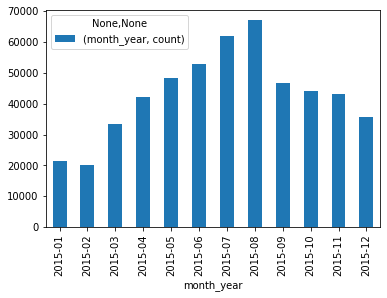

In [44]:
booking_set_frankfurt_2015.groupby(['month_year']).agg({'month_year': ['count']}).plot(kind='bar')

In [45]:
#number of bookings increasing constantly until August. Rapidly sloping in September and constantly decreasing 
#until the end of the year.
#the summer months and the winter months are in relation to the booking frequency

## Amount bookings Frankfurt 2016:

In [46]:
start_date_2016 = '2016-01-01 00:00:00'
end_date_2016 = '2016-12-31 23:59:59'
filtered_dates_2016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_2016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_2016)
booking_set_frankfurt_2016 = booking_set_frankfurt.loc[filtered_dates_2016]
booking_set_frankfurt_2016

,BOOKING_HAL_ID,DATE_BOOKING
8909418,34947898,2016-01-01 00:12:33
8914012,34947899,2016-01-01 00:12:46
8910295,34947919,2016-01-01 00:23:17
8908794,34947924,2016-01-01 00:24:44
8909404,34947929,2016-01-01 00:25:45
...,...,...
14613160,43561784,2016-12-31 23:13:00
14613511,43561828,2016-12-31 23:23:28
14612056,43561832,2016-12-31 23:24:03
14615815,43561863,2016-12-31 23:28:04


Result: 915.038

In [47]:
booking_set_frankfurt_2016['month_year'] = booking_set_frankfurt_2016['DATE_BOOKING'].dt.to_period('M')
booking_set_frankfurt_2016['month_year'].value_counts(normalize=True)

2016-08    0.134741
2016-07    0.122666
2016-09    0.118426
2016-06    0.114547
2016-05    0.107976
2016-04    0.090661
2016-10    0.073858
2016-11    0.060682
2016-03    0.051411
2016-12    0.044442
2016-02    0.044056
2016-01    0.036535
Freq: M, Name: month_year, dtype: float64

In [48]:
booking_set_frankfurt_2016['month_year'].value_counts() 

2016-08    123293
2016-07    112244
2016-09    108364
2016-06    104815
2016-05     98802
2016-04     82958
2016-10     67583
2016-11     55526
2016-03     47043
2016-12     40666
2016-02     40313
2016-01     33431
Freq: M, Name: month_year, dtype: int64

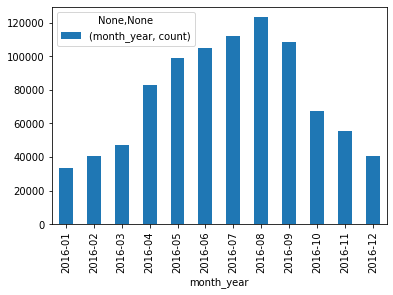

In [49]:
booking_set_frankfurt_2016.groupby(['month_year']).agg({'month_year': ['count']}).plot(kind='bar')

In [50]:
#see explanation for booking frequency plot 2015
#compared to 2015, the booking frequency for all months has increased
#the same ratio of summer months and winter months can be seen except that there is no rapid drop between Augusut 
#and September
#therefore bookings between October and December are relatively less compared to 2015

## Amount of bookings in the seasons:


In [51]:
#2015
#December, January, February
start_date_dec_2015 = '2015-12-01 00:00:00'
end_date_dec_2015 = '2015-12-31 23:59:59'
filtered_dates_dec_2015 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_dec_2015) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_dec_2015) 
booking_set_frankfurt_dec_2015 = booking_set_frankfurt.loc[filtered_dates_dec_2015]
booking_set_frankfurt_dec_2015

,BOOKING_HAL_ID,DATE_BOOKING
8627664,34451014,2015-12-01 00:01:14
8628529,34451039,2015-12-01 00:05:35
8627485,34451050,2015-12-01 00:07:01
8627189,34451051,2015-12-01 00:07:05
8628465,34451064,2015-12-01 00:08:25
...,...,...
8910063,34947687,2015-12-31 23:18:05
8909106,34947697,2015-12-31 23:19:40
8914589,34947717,2015-12-31 23:22:36
8909758,34947732,2015-12-31 23:28:19


In [52]:
start_date_winter_2015 = '2015-01-01 00:00:00'
end_date_winter_2015 = '2015-02-28 23:59:59'
filtered_dates_winter_2015 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_winter_2015) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_winter_2015) 
booking_set_frankfurt_winter_2015 = booking_set_frankfurt.loc[filtered_dates_winter_2015]
booking_set_frankfurt_winter_2015

,BOOKING_HAL_ID,DATE_BOOKING
4284612,27689006,2015-01-01 00:21:22
4285336,27689041,2015-01-01 00:30:20
4285873,27689080,2015-01-01 00:42:51
4286542,27689151,2015-01-01 01:00:19
4286567,27689154,2015-01-01 01:00:47
...,...,...
4613551,28356046,2015-02-28 23:25:03
4616225,28356058,2015-02-28 23:26:35
4616709,28356074,2015-02-28 23:30:21
4616246,28356112,2015-02-28 23:38:01


In [53]:
#combine the two frames
frames = [booking_set_frankfurt_dec_2015, booking_set_frankfurt_winter_2015]
winter_2015 = pd.concat(frames)
winter_2015

,BOOKING_HAL_ID,DATE_BOOKING
8627664,34451014,2015-12-01 00:01:14
8628529,34451039,2015-12-01 00:05:35
8627485,34451050,2015-12-01 00:07:01
8627189,34451051,2015-12-01 00:07:05
8628465,34451064,2015-12-01 00:08:25
...,...,...
4613551,28356046,2015-02-28 23:25:03
4616225,28356058,2015-02-28 23:26:35
4616709,28356074,2015-02-28 23:30:21
4616246,28356112,2015-02-28 23:38:01


In [54]:
##March, April, Mai
start_date_spring_2015 = '2015-03-01 00:00:00'
end_date_spring_2015 = '2015-05-31 23:59:59'
filtered_dates_spring_2015 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_spring_2015) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_spring_2015)
booking_set_frankfurt_spring_2015 = booking_set_frankfurt.loc[filtered_dates_spring_2015]
booking_set_frankfurt_spring_2015

,BOOKING_HAL_ID,DATE_BOOKING
4613273,28356212,2015-03-01 00:00:11
4613211,28356262,2015-03-01 00:11:22
4612966,28356281,2015-03-01 00:16:26
4614362,28356284,2015-03-01 00:16:58
4612668,28356309,2015-03-01 00:21:41
...,...,...
5735664,30141540,2015-05-31 23:46:10
5740159,30141566,2015-05-31 23:51:55
5732560,30141571,2015-05-31 23:53:12
5735701,30141576,2015-05-31 23:54:01


In [55]:
##June, Juli, August
start_date_summer_2015 = '2015-06-01 00:00:00'
end_date_summer_2015 = '2015-08-31 23:59:59'
filtered_dates_summer_2015 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_summer_2015) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_summer_2015)
booking_set_frankfurt_summer_2015 = booking_set_frankfurt.loc[filtered_dates_summer_2015]
booking_set_frankfurt_summer_2015

,BOOKING_HAL_ID,DATE_BOOKING
5734026,30141616,2015-06-01 00:02:22
5735467,30141637,2015-06-01 00:05:41
5739521,30141638,2015-06-01 00:06:14
5736218,30141639,2015-06-01 00:06:14
5736382,30141658,2015-06-01 00:10:44
...,...,...
7469969,32604746,2015-08-31 23:53:50
7463229,32604748,2015-08-31 23:53:53
7464666,32604784,2015-08-31 23:57:46
7463743,32604788,2015-08-31 23:58:15


In [56]:
##September, October, November
start_date_fall_2015 = '2015-09-01 00:00:00'
end_date_fall_2015 = '2015-11-30 23:59:59'
filtered_dates_fall_2015 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_fall_2015) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_fall_2015)
booking_set_frankfurt_fall_2015 = booking_set_frankfurt.loc[filtered_dates_fall_2015]
booking_set_frankfurt_fall_2015

,BOOKING_HAL_ID,DATE_BOOKING
7465906,32604816,2015-09-01 00:01:13
7464562,32604822,2015-09-01 00:01:45
7465883,32604835,2015-09-01 00:03:06
7463981,32604862,2015-09-01 00:07:45
7463916,32604873,2015-09-01 00:09:57
...,...,...
8628140,34450941,2015-11-30 23:46:33
8629132,34450942,2015-11-30 23:46:47
8627484,34450946,2015-11-30 23:47:22
8628455,34450967,2015-11-30 23:50:24


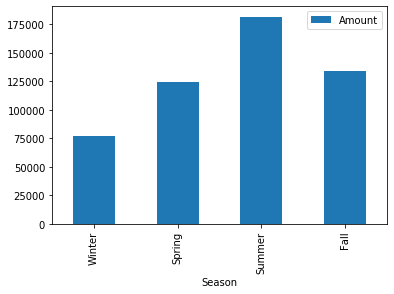

In [57]:
#simple plot for the bookings per season
data2015 = {'Season':['Winter', 'Spring', 'Summer', 'Fall'],
        'Amount':[77124, 124013, 181772 , 133696]}
data2015 = pd.DataFrame(data2015)
data2015.plot('Season', kind='bar')

In [58]:
#booking frequencies are aggregated on seasons
#the same trend as the monthly visualization can be seen
#most bookings are in summer and the fewest in the winter.
#spring and autumn behave almost linearly to the summer and winter months

In [59]:
#do the same for the year 2016

In [60]:
#2016
#December, January, February
start_date_dec_2016 = '2016-12-01 00:00:00'
end_date_dec_2016 = '2016-12-31 23:59:59'
filtered_dates_dec_2016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_dec_2016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_dec_2016) 
booking_set_frankfurt_dec_2016 = booking_set_frankfurt.loc[filtered_dates_dec_2016]
start_date_winter_2016 = '2016-01-01 00:00:00'
end_date_winter_2016 = '2016-02-29 23:59:59'
filtered_dates_winter_2016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_winter_2016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_winter_2016) 
booking_set_frankfurt_winter_2016 = booking_set_frankfurt.loc[filtered_dates_winter_2016]
booking_set_frankfurt_winter_2016
frames2 = [booking_set_frankfurt_dec_2016, booking_set_frankfurt_winter_2016]
winter_2016 = pd.concat(frames2)
winter_2016

,BOOKING_HAL_ID,DATE_BOOKING
14351578,43072015,2016-12-01 00:01:12
14346745,43072016,2016-12-01 00:01:15
14350998,43072028,2016-12-01 00:02:47
14348120,43072089,2016-12-01 00:12:28
14347478,43072100,2016-12-01 00:13:55
...,...,...
9403654,35850780,2016-02-29 23:43:39
9402767,35850797,2016-02-29 23:48:46
9403005,35850805,2016-02-29 23:51:12
9402768,35850812,2016-02-29 23:53:43


In [61]:
##March, April, Mai
start_date_spring_2016 = '2016-03-01 00:00:00'
end_date_spring_2016 = '2016-05-31 23:59:59'
filtered_dates_spring_2016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_spring_2016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_spring_2016)
booking_set_frankfurt_spring_2016 = booking_set_frankfurt.loc[filtered_dates_spring_2016]
booking_set_frankfurt_spring_2016

,BOOKING_HAL_ID,DATE_BOOKING
9401886,35850839,2016-03-01 00:05:27
9401087,35850909,2016-03-01 00:23:46
9402358,35850921,2016-03-01 00:29:03
9402409,35850926,2016-03-01 00:30:33
9404378,35850952,2016-03-01 00:40:43
...,...,...
10858213,38097229,2016-05-31 23:58:59
10858382,38097231,2016-05-31 23:59:09
10857852,38097232,2016-05-31 23:59:16
10859605,38097234,2016-05-31 23:59:44


In [62]:
##June, Juli, August
start_date_summer_2016 = '2016-06-01 00:00:00'
end_date_summer_2016 = '2016-08-31 23:59:59'
filtered_dates_summer_2016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_summer_2016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_summer_2016)
booking_set_frankfurt_summer_2016 = booking_set_frankfurt.loc[filtered_dates_summer_2016]
booking_set_frankfurt_summer_2016

,BOOKING_HAL_ID,DATE_BOOKING
10859600,38097243,2016-06-01 00:00:28
10859643,38097264,2016-06-01 00:02:35
10860449,38097282,2016-06-01 00:04:24
10857952,38097283,2016-06-01 00:04:27
10858114,38097284,2016-06-01 00:04:31
...,...,...
12891705,40894792,2016-08-31 23:57:32
12890129,40894793,2016-08-31 23:57:35
12891584,40894798,2016-08-31 23:57:54
12890434,40894819,2016-08-31 23:59:52


In [63]:
##September, October, November
start_date_fall_2016 = '2016-09-01 00:00:00'
end_date_fall_2016 = '2016-11-30 23:59:59'
filtered_dates_fall_2016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_fall_2016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_fall_2016)
booking_set_frankfurt_fall_2016 = booking_set_frankfurt.loc[filtered_dates_fall_2016]
booking_set_frankfurt_fall_2016

,BOOKING_HAL_ID,DATE_BOOKING
12888365,40894821,2016-09-01 00:00:02
12888976,40894835,2016-09-01 00:01:08
12896868,40894841,2016-09-01 00:01:32
12897793,40894850,2016-09-01 00:02:40
12890339,40894899,2016-09-01 00:07:02
...,...,...
14352023,43071937,2016-11-30 23:47:50
14347463,43071947,2016-11-30 23:49:09
14346902,43071965,2016-11-30 23:52:11
14345952,43071979,2016-11-30 23:54:41


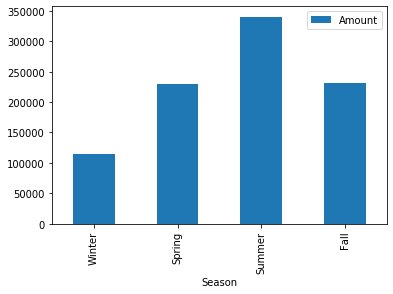

In [64]:
#simple plot for the bookings per season 2016
data2016 = {'Season':['Winter', 'Spring', 'Summer', 'Fall'],
        'Amount':[114410, 228803, 340352, 231473]}
data2016 = pd.DataFrame(data2016)
data2016.plot('Season', kind='bar')

In [65]:
#compare the explanation for 2015
#again total number of bookings increased for each season in respect to 2015

## Amount of bookings in respect to the week days


In [66]:
#group bookings by the day of week in the year 2015
hours_size_2015 = booking_set_frankfurt_2015.groupby(booking_set_frankfurt_2015['DATE_BOOKING'].dt.weekday_name).size()

In [67]:
hours_size_2015

DATE_BOOKING
Friday       80186
Monday       75581
Saturday     54597
Sunday       48097
Thursday     84268
Tuesday      84773
Wednesday    89103
dtype: int64

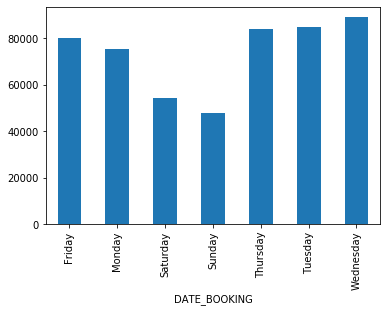

In [68]:
hours_size_2015.plot(kind='bar')

In [69]:
#booking frequencies on individual days of the week are approximately similar
#with the exception of weekend days, significantly fewer bookings are made. 
#Sunday is the minimum where most people don't have to work.
#on Wednesday most bookings are made

In [70]:
#group bookings by the day of week in the year 2016
hours_size_2016 = booking_set_frankfurt_2016.groupby(booking_set_frankfurt_2016['DATE_BOOKING'].dt.weekday_name).size()

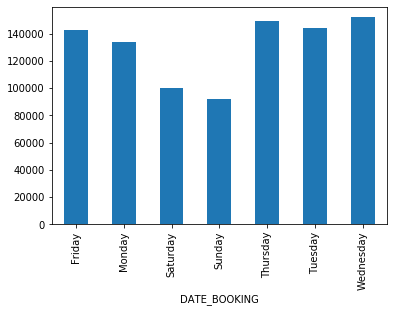

In [71]:
hours_size_2016.plot(kind='bar')

In [72]:
#compare the explanation for 2015
#again total number of bookings increased for each weekday in respect to 2015

## Amount of bookings for the different hours during the day

### Bookings per hour/day 2015

In [73]:
#2015 #bookings per hours the day
hours_day_2015 = booking_set_frankfurt_2015.groupby(booking_set_frankfurt_2015['DATE_BOOKING'].dt.hour).size()

In [74]:
hours_day_2015

DATE_BOOKING
0      8928
1      8431
2      6252
3      4281
4      2423
5      2818
6      7045
7     25520
8     44169
9     27011
10    17914
11    21480
12    28363
13    28429
14    25298
15    29197
16    35486
17    41593
18    42283
19    34412
20    25835
21    19866
22    16836
23    12735
dtype: int64

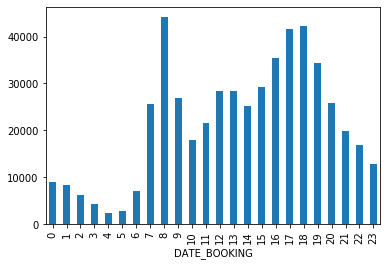

In [75]:
hours_day_2015.plot(kind='bar')

In [76]:
#booking frequency of individual hours varies greatly
#in the morning (7.00 am - 9.00 am) and in the evening (4.00 pm - 7.00 pm), booking rates are on top
#regarding the normal working hours of employees, keyword 'rushhour'
#one might assume that many customers rent bicycles to get to work and come back
#in the evening, the booking time varies more than in the morning
#this may indicate that most employees start at a similar time but end the working day at more different times

In [77]:
#2015 get the different time formats out of the date booking
booking_set_frankfurt_2015['year'] = booking_set_frankfurt_2015['DATE_BOOKING'].dt.strftime('%Y')
booking_set_frankfurt_2015['month'] = booking_set_frankfurt_2015['DATE_BOOKING'].dt.strftime('%b')
booking_set_frankfurt_2015['date'] = booking_set_frankfurt_2015['DATE_BOOKING'].dt.strftime('%d')
booking_set_frankfurt_2015['hour'] = booking_set_frankfurt_2015['DATE_BOOKING'].dt.strftime('%H')
booking_set_frankfurt_2015['Day_of_week'] = booking_set_frankfurt_2015['DATE_BOOKING'].dt.strftime('%a')

In [78]:
new_booking_set_frankfurt_2015 = booking_set_frankfurt_2015.loc[:,['BOOKING_HAL_ID', 'Day_of_week', 'hour']]

In [79]:
#now get it in a nice dispay py pivoting the table
pd.set_option('display.max_columns', 24)
res = new_booking_set_frankfurt_2015.groupby(['Day_of_week', 'hour'], as_index = False).count()

### Table of booking Amount for the hours of the week days (2015)

In [80]:
#make day_of_week to index
#hour should be new column 
res.pivot(index='Day_of_week', columns='hour', values='BOOKING_HAL_ID')

hour,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Day_of_week,,,,,,,,,,,,,,,,,,,,,,,,
Fri,1385,1274,934,559,265,366,1220,4503,7896,4484,2604,3374,4607,4840,4182,4648,5605,6239,5721,4625,3582,2800,2341,2132
Mon,703,466,209,113,84,304,1221,4415,7677,4434,2639,2964,3940,3866,3210,4072,5475,6541,6982,5591,3972,3000,2282,1421
Sat,1925,2216,1905,1404,814,514,360,559,1031,1794,2411,2711,3204,3700,3586,3591,3262,3627,3448,3340,2995,2334,2046,1820
Sun,1861,2274,1936,1417,843,586,325,401,594,1290,1792,2078,2532,2832,3269,3356,3385,3483,3423,3157,2394,1981,1674,1214
Thu,1291,991,616,434,230,381,1191,4855,8555,4673,2745,3342,4651,4265,3733,4659,5870,7017,7185,5363,4185,3072,2808,2156
Tue,763,495,276,148,82,329,1301,5448,8994,5019,2798,3489,4576,4307,3538,4270,5775,7195,7716,6159,4361,3209,2696,1829
Wed,1000,715,376,206,105,338,1427,5339,9422,5317,2925,3522,4853,4619,3780,4601,6114,7491,7808,6177,4346,3470,2989,2163


### Amount of bookings for the hours of the day (2016)

In [81]:
#2016 #gesamte Stunden in der Woche
hours_day_2016 = booking_set_frankfurt_2016.groupby(booking_set_frankfurt_2016['DATE_BOOKING'].dt.hour).size()

In [82]:
hours_day_2016

DATE_BOOKING
0     16041
1     13891
2      9935
3      6296
4      4028
5      4655
6     11871
7     41964
8     74818
9     47164
10    30976
11    37808
12    49164
13    51004
14    46584
15    52091
16    61370
17    74800
18    77994
19    63420
20    48558
21    36674
22    30323
23    23609
dtype: int64

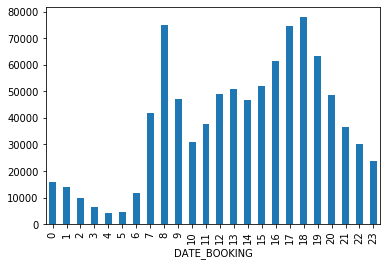

In [83]:
hours_day_2016.plot(kind='bar')

In [84]:
#compared the explanation for 2015, the same trend can be seen
#at night, the least bikes are rented
#as already mentioned, more bicycles are rented in total than in 2015

In [85]:
#the same procedure for 2016
booking_set_frankfurt_2016['year'] = booking_set_frankfurt_2016['DATE_BOOKING'].dt.strftime('%Y')
booking_set_frankfurt_2016['month'] = booking_set_frankfurt_2016['DATE_BOOKING'].dt.strftime('%b')
booking_set_frankfurt_2016['date'] = booking_set_frankfurt_2016['DATE_BOOKING'].dt.strftime('%d')
booking_set_frankfurt_2016['hour'] = booking_set_frankfurt_2016['DATE_BOOKING'].dt.strftime('%H')
booking_set_frankfurt_2016['Day_of_week'] = booking_set_frankfurt_2016['DATE_BOOKING'].dt.strftime('%a')

new_booking_set_frankfurt_2016 = booking_set_frankfurt_2016.loc[:,['BOOKING_HAL_ID', 'Day_of_week', 'hour']]

res2 = new_booking_set_frankfurt_2016.groupby(['Day_of_week', 'hour'], as_index = False).count()

### Table of bookings for the different hours of the week days (2016)

In [86]:
res2.pivot(index='Day_of_week', columns='hour', values='BOOKING_HAL_ID')

hour,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Day_of_week,,,,,,,,,,,,,,,,,,,,,,,,
Fri,2523,2018,1312,790,433,634,1941,7443,13206,7988,4631,6064,8123,8218,7415,8513,10053,11153,10711,8546,6898,5350,4605,4052
Mon,1192,789,399,197,173,553,1856,7225,13083,7757,4662,5164,6769,7072,6144,7362,9323,11902,13074,10129,7377,5453,3960,2683
Sat,3645,3841,3021,2031,1326,852,584,989,1915,3200,4127,5116,6103,6682,6987,6805,6211,6879,6827,6406,5473,4373,3590,3477
Sun,3480,3901,3281,2254,1473,958,559,694,1183,2429,3441,4051,4871,5928,6392,6657,6609,7066,6769,6194,4950,3811,3039,2163
Thu,2111,1381,865,522,315,547,2211,7925,14405,8610,4803,5860,8151,8010,6876,7916,9766,12466,13365,10413,7662,5835,4946,4190
Tue,1427,869,486,225,152,545,2265,8768,15139,8370,4452,5575,7380,7487,6368,7302,9703,12318,13402,10618,7715,5817,4767,3141
Wed,1663,1092,571,277,156,566,2455,8920,15887,8810,4860,5978,7767,7607,6402,7536,9705,13016,13846,11114,8483,6035,5416,3903


## Comparison of the amount of bookings per month in 2015/2016

In [87]:
booking_months1 = booking_set_frankfurt_2015.loc[:,['BOOKING_HAL_ID', 'month']]
firstyear = booking_months1.groupby(["month"], as_index = False).count()
booking_months2 = booking_set_frankfurt_2016.loc[:,['BOOKING_HAL_ID', 'month']]
secondyear = booking_months2.groupby(["month"], as_index = False).count()

In [88]:
#this is needed to sort the table after the days of the week
sorter = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sorterIndex = dict(zip(sorter,range(len(sorter))))
firstyear['Day_id'] = firstyear.index
firstyear['Day_id'] = firstyear['month'].map(sorterIndex)
firstyear.sort_values('Day_id', inplace=True)

In [89]:
#this is needed to sort the table after the days of the week
sorter = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sorterIndex = dict(zip(sorter,range(len(sorter))))
secondyear['Day_id'] = secondyear.index
secondyear['Day_id'] = secondyear['month'].map(sorterIndex)
secondyear.sort_values('Day_id', inplace=True)

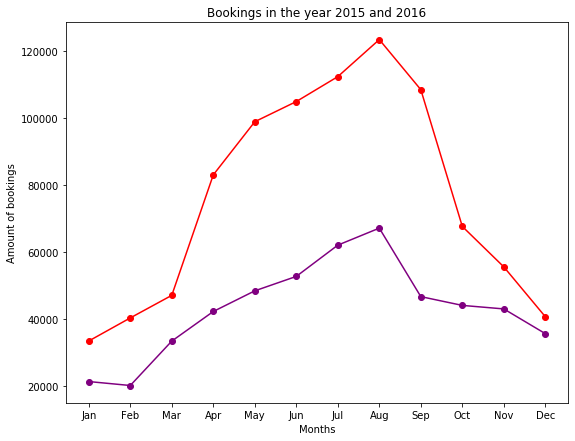

In [90]:
#this plot shows the bikes at the main train station that are leaving in violet and that are arriving in red
# Create the plot space upon which to plot the data 
fig, ax = plt.subplots(figsize=(9, 7))

# Add the x-axis and the y-axis to the plot
ax.plot(firstyear['month'],
        firstyear['BOOKING_HAL_ID'], '-o',
        color='purple')

ax.plot(secondyear['month'],
        secondyear['BOOKING_HAL_ID'], '-o',
        color='red')
# Set title and labels for axes
ax.set(xlabel="Months",
       ylabel="Amount of bookings",
       title="Bookings in the year 2015 and 2016")
plt.show()

In [91]:
#bookings for 2016 outweigh the 2015 bookings in each month
#2016: a rapid increase in bookings compared to the previous year can be seen between April and September
#in some cases, there are outliers that do not fit into the scheme, such as the decrease in February 2015 or 
#an extreme rise between March and April in 2016. 
#since the booking quantities are concerned here, not outliers should be expected.
#this may indicate that bookings are sometimes flexible or could determined by other factors.

## Average duration of bookings

In [92]:
# in order to use the same variable name as above, we read the booking dataset in the same way as before

In [93]:
#this goes for both years
#first get the dates
#booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", delimiter=';')

booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]

booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True) #sort the data after the date, ascending
booking_set_frankfurt['DATE_BOOKING'] = pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'])
booking_set_frankfurt['DATE_BOOKING'].dt.strftime('%Y-%m-%d %X')
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]

In [94]:
booking_set_frankfurt_20152016['DATE_UNTIL'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_UNTIL'])
booking_set_frankfurt_20152016['DATE_UNTIL'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['DATE_FROM'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_FROM'])
booking_set_frankfurt_20152016['DATE_FROM'].dt.strftime('%Y-%m-%d %X')

4284612     2015-01-01 00:21:22
4285336     2015-01-01 00:30:20
4285873     2015-01-01 00:42:51
4286542     2015-01-01 01:00:19
4286567     2015-01-01 01:00:47
                   ...         
14613160    2016-12-31 23:13:00
14613511    2016-12-31 23:23:28
14612056    2016-12-31 23:24:03
14615815    2016-12-31 23:28:04
14612244    2016-12-31 23:40:33
Name: DATE_FROM, Length: 1431643, dtype: object

In [95]:
booking_set_frankfurt_20152016['duration'] = booking_set_frankfurt_20152016['DATE_UNTIL'] - booking_set_frankfurt_20152016['DATE_FROM']

### Amount of bookings below a certain minute limit

In [96]:
#run this through multiple times by changing the minute count to get the hard coded result below
duration_oneminute = booking_set_frankfurt_20152016[booking_set_frankfurt_20152016.duration < '00:05:00']
print(duration_oneminute.shape)

(166839, 18)


Amount of bikes that are under certain amount of minutes duration:

Hardcoded result from before: 
1. 1 Minute: 5412
2. 2 Minutes: 21464
3. 3 Minutes: 44362
4. 4 Minutes: 94586
5. 5 Minutes: 166839

### Amount of bookings above a certain day limit

In [97]:
#same as before
duration_oneday = booking_set_frankfurt_20152016[booking_set_frankfurt_20152016.duration > '14 days 00:00:00']
print(duration_oneday.shape)

(94, 18)


Hardcoded: Amount of bikes that are over a certain amount of days duration:
1. 1 Day: 3115
2. 2 Days: 1159
3. 3 Days: 661
4. 4 Days: 440
5. Days: 323
6. Days: 239
7. Days: 198
8. Days: 162
9. Days: 146
10. Days: 136
11. Days: 125
12. Days: 109
13. Days: 98
14. Days: 94

In [98]:
booking_set_frankfurt_20152016['year'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%Y')
booking_set_frankfurt_20152016['month'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%b')
booking_set_frankfurt_20152016['date'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%d')
booking_set_frankfurt_20152016['hour'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%H')
booking_set_frankfurt_20152016['Day_of_week'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%a')

In [99]:
booking_duration = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'Day_of_week', 'hour', 'duration']]
booking_duration

,BOOKING_HAL_ID,Day_of_week,hour,duration
4284612,27689006,Thu,00,0 days 00:03:56
4285336,27689041,Thu,00,0 days 00:11:32
4285873,27689080,Thu,00,0 days 00:25:58
4286542,27689151,Thu,01,0 days 00:11:00
4286567,27689154,Thu,01,0 days 00:10:33
...,...,...,...,...
14613160,43561784,Sat,23,1 days 09:08:32
14613511,43561828,Sat,23,0 days 00:22:31
14612056,43561832,Sat,23,0 days 00:08:47
14615815,43561863,Sat,23,0 days 00:05:21


### Mean duration for the week days

In [100]:
booking_duration['duration'] = pd.to_numeric(booking_duration['duration'])
booking_duration_mean = booking_duration.groupby(["Day_of_week"], as_index = False)['duration'].mean()
booking_duration_mean['duration'] = pd.to_timedelta(booking_duration_mean['duration'])
booking_duration_mean

,Day_of_week,duration
0,Fri,00:31:32.055644
1,Mon,00:35:32.290815
2,Sat,00:40:40.699059
3,Sun,00:38:56.724427
4,Thu,00:30:32.577930
5,Tue,00:30:19.203179
6,Wed,00:28:09.494671


In [101]:
#this is needed to sort the table after the days of the week
sorter = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sorterIndex = dict(zip(sorter,range(len(sorter))))
booking_duration_mean['Day_id'] = booking_duration_mean.index
booking_duration_mean['Day_id'] = booking_duration_mean['Day_of_week'].map(sorterIndex)
booking_duration_mean.sort_values('Day_id', inplace=True)

In [102]:
booking_duration_mean

,Day_of_week,duration,Day_id
1,Mon,00:35:32.290815,0
5,Tue,00:30:19.203179,1
6,Wed,00:28:09.494671,2
4,Thu,00:30:32.577930,3
0,Fri,00:31:32.055644,4
2,Sat,00:40:40.699059,5
3,Sun,00:38:56.724427,6


In [103]:
#round the time to make it better for plotting
booking_duration_mean['duration']  = round(booking_duration_mean['duration'].dt.total_seconds()/60)

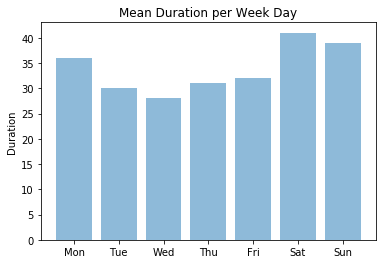

In [104]:
#plot for the mean duration per week day
y_pos = np.arange(len(booking_duration_mean['Day_of_week']))
plt.bar(y_pos, booking_duration_mean['duration'], align='center', alpha=0.5)
plt.xticks(y_pos, booking_duration_mean['Day_of_week'])
plt.ylabel('Duration')
plt.title('Mean Duration per Week Day')

plt.show()

In [105]:
#booking mean duration on weekdays are approximately similar, except the weekend
#there, the booking time is higher on average. 
#Saturday exceeds Sunday.
#bicycles could be used in the week to drive to and from work.
#on weekend the bikes may be used for private rides without a defined start- and final destination or without 
#time pressure

### mean duration for the different hours a day

In [106]:
#Now do the same process for hours of the day

In [107]:
booking_duration = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'Day_of_week', 'hour', 'duration']]
booking_duration

,BOOKING_HAL_ID,Day_of_week,hour,duration
4284612,27689006,Thu,00,0 days 00:03:56
4285336,27689041,Thu,00,0 days 00:11:32
4285873,27689080,Thu,00,0 days 00:25:58
4286542,27689151,Thu,01,0 days 00:11:00
4286567,27689154,Thu,01,0 days 00:10:33
...,...,...,...,...
14613160,43561784,Sat,23,1 days 09:08:32
14613511,43561828,Sat,23,0 days 00:22:31
14612056,43561832,Sat,23,0 days 00:08:47
14615815,43561863,Sat,23,0 days 00:05:21


In [108]:
booking_duration['duration'] = pd.to_numeric(booking_duration['duration'])
booking_duration_mean = booking_duration.groupby(["hour"], as_index = False)['duration'].mean()
booking_duration_mean['duration'] = pd.to_timedelta(booking_duration_mean['duration'])
booking_duration_mean

,hour,duration
0,00,00:34:40.516600
1,01,00:31:00.292446
2,02,00:29:12.395193
3,03,00:33:22.050675
4,04,00:39:12.001395
5,05,00:23:45.539140
6,06,00:20:14.509727
7,07,00:22:14.720363
8,08,00:21:27.503130
9,09,00:23:47.541462


In [109]:
booking_duration_mean['duration']  = round(booking_duration_mean['duration'].dt.total_seconds()/60)

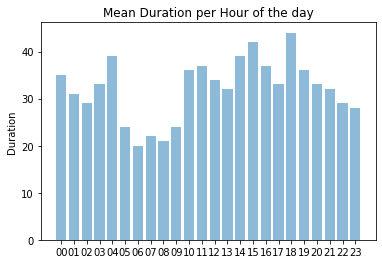

In [110]:
#plot for the mean duration per week day
y_pos = np.arange(len(booking_duration_mean['hour']))
plt.bar(y_pos, booking_duration_mean['duration'], align='center', alpha=0.5)
plt.xticks(y_pos, booking_duration_mean['hour'])
plt.ylabel('Duration')
plt.title('Mean Duration per Hour of the day')

plt.show()

In [111]:
#the average travel time depending on the booking hour of the day is shown.
#at each hour, the average journey time is between 15 and 30 minutes.
#this suggests that rented bicycles are mostly used to cope with journey times between this interval.
#it is noticeable that booked bicycles between 5.00 a.m. and 9.00 a.m. have significantly shorter travel times than 
#the other hours.
#customers who book a bike during this time may be in a hurry.
#if the journey time lasts longer, customers choose a different kind of transport. 

### Duration for the different seasons

In [112]:
#this goes for both years
#first get the dates
#booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", delimiter=';')

booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]

booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True) #sort the data after the date, ascending
booking_set_frankfurt['DATE_BOOKING'] = pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'])
booking_set_frankfurt['DATE_BOOKING'].dt.strftime('%Y-%m-%d %X')
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]

In [113]:
booking_set_frankfurt_20152016['DATE_UNTIL'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_UNTIL'])
booking_set_frankfurt_20152016['DATE_UNTIL'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['DATE_FROM'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_FROM'])
booking_set_frankfurt_20152016['DATE_FROM'].dt.strftime('%Y-%m-%d %X')

4284612     2015-01-01 00:21:22
4285336     2015-01-01 00:30:20
4285873     2015-01-01 00:42:51
4286542     2015-01-01 01:00:19
4286567     2015-01-01 01:00:47
                   ...         
14613160    2016-12-31 23:13:00
14613511    2016-12-31 23:23:28
14612056    2016-12-31 23:24:03
14615815    2016-12-31 23:28:04
14612244    2016-12-31 23:40:33
Name: DATE_FROM, Length: 1431643, dtype: object

In [114]:
booking_set_frankfurt_20152016['duration'] = booking_set_frankfurt_20152016['DATE_UNTIL'] - booking_set_frankfurt_20152016['DATE_FROM']
booking_duration = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'DATE_BOOKING', 'duration']]

In [115]:
booking_duration

,BOOKING_HAL_ID,DATE_BOOKING,duration
4284612,27689006,2015-01-01 00:21:22,0 days 00:03:56
4285336,27689041,2015-01-01 00:30:20,0 days 00:11:32
4285873,27689080,2015-01-01 00:42:51,0 days 00:25:58
4286542,27689151,2015-01-01 01:00:19,0 days 00:11:00
4286567,27689154,2015-01-01 01:00:47,0 days 00:10:33
...,...,...,...
14613160,43561784,2016-12-31 23:13:00,1 days 09:08:32
14613511,43561828,2016-12-31 23:23:28,0 days 00:22:31
14612056,43561832,2016-12-31 23:24:03,0 days 00:08:47
14615815,43561863,2016-12-31 23:28:04,0 days 00:05:21


In [116]:
#winter
start_date1 = '2015-01-01 00:00:00'
end_date1 = '2015-02-28 23:59:59'
filtered_dates_winter_one = (booking_duration['DATE_BOOKING'] >= start_date1) & (booking_duration['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_winter_one = booking_duration.loc[filtered_dates_winter_one]
booking_set_frankfurt_winter_one

,BOOKING_HAL_ID,DATE_BOOKING,duration
4284612,27689006,2015-01-01 00:21:22,00:03:56
4285336,27689041,2015-01-01 00:30:20,00:11:32
4285873,27689080,2015-01-01 00:42:51,00:25:58
4286542,27689151,2015-01-01 01:00:19,00:11:00
4286567,27689154,2015-01-01 01:00:47,00:10:33
...,...,...,...
4613551,28356046,2015-02-28 23:25:03,00:20:24
4616225,28356058,2015-02-28 23:26:35,00:08:32
4616709,28356074,2015-02-28 23:30:21,00:12:58
4616246,28356112,2015-02-28 23:38:01,00:19:42


In [117]:
#winter
start_date2 = '2015-12-01 00:00:00'
end_date2 = '2016-02-29 23:59:59'
filtered_dates_winter_two = (booking_duration['DATE_BOOKING'] >= start_date2) & (booking_duration['DATE_BOOKING'] <= end_date2) 
booking_set_frankfurt_winter_two = booking_duration.loc[filtered_dates_winter_two]
booking_set_frankfurt_winter_two

,BOOKING_HAL_ID,DATE_BOOKING,duration
8627664,34451014,2015-12-01 00:01:14,00:12:57
8628529,34451039,2015-12-01 00:05:35,00:07:10
8627485,34451050,2015-12-01 00:07:01,00:03:42
8627189,34451051,2015-12-01 00:07:05,00:11:52
8628465,34451064,2015-12-01 00:08:25,00:13:56
...,...,...,...
9403654,35850780,2016-02-29 23:43:39,00:20:30
9402767,35850797,2016-02-29 23:48:46,00:19:06
9403005,35850805,2016-02-29 23:51:12,00:11:14
9402768,35850812,2016-02-29 23:53:43,00:07:47


In [118]:
#winter
start_date3 = '2016-12-01 00:00:00'
end_date3 = '2016-12-31 23:59:59'
filtered_dates_winter_three = (booking_duration['DATE_BOOKING'] >= start_date3) & (booking_duration['DATE_BOOKING'] <= end_date3) 
booking_set_frankfurt_winter_three = booking_duration.loc[filtered_dates_winter_three]
booking_set_frankfurt_winter_three

,BOOKING_HAL_ID,DATE_BOOKING,duration
14351578,43072015,2016-12-01 00:01:12,0 days 00:03:10
14346745,43072016,2016-12-01 00:01:15,0 days 00:05:42
14350998,43072028,2016-12-01 00:02:47,0 days 00:09:45
14348120,43072089,2016-12-01 00:12:28,0 days 00:06:31
14347478,43072100,2016-12-01 00:13:55,0 days 00:02:24
...,...,...,...
14613160,43561784,2016-12-31 23:13:00,1 days 09:08:32
14613511,43561828,2016-12-31 23:23:28,0 days 00:22:31
14612056,43561832,2016-12-31 23:24:03,0 days 00:08:47
14615815,43561863,2016-12-31 23:28:04,0 days 00:05:21


In [119]:
#winter
frames = [booking_set_frankfurt_winter_one, booking_set_frankfurt_winter_two, booking_set_frankfurt_winter_three]
winter = pd.concat(frames)

In [120]:
winter['duration'] = pd.to_numeric(winter['duration'])
winter_duration_mean = winter['duration'].mean()
winter_duration_mean = pd.to_timedelta(winter_duration_mean)
winter_duration_mean

Timedelta('0 days 00:33:09.589582')

In [121]:
#spring

In [122]:
start_date1 = '2015-03-01 00:00:00'
end_date1 = '2015-05-31 23:59:59'
filtered_dates_spring_one = (booking_duration['DATE_BOOKING'] >= start_date1) & (booking_duration['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_spring_one = booking_duration.loc[filtered_dates_spring_one]
booking_set_frankfurt_spring_one

,BOOKING_HAL_ID,DATE_BOOKING,duration
4613273,28356212,2015-03-01 00:00:11,00:19:50
4613211,28356262,2015-03-01 00:11:22,00:12:17
4612966,28356281,2015-03-01 00:16:26,00:40:47
4614362,28356284,2015-03-01 00:16:58,00:05:12
4612668,28356309,2015-03-01 00:21:41,00:11:31
...,...,...,...
5735664,30141540,2015-05-31 23:46:10,00:19:02
5740159,30141566,2015-05-31 23:51:55,00:14:36
5732560,30141571,2015-05-31 23:53:12,00:19:20
5735701,30141576,2015-05-31 23:54:01,00:08:40


In [123]:
start_date2 = '2016-03-01 00:00:00'
end_date2 = '2016-05-31 23:59:59'
filtered_dates_spring_two = (booking_duration['DATE_BOOKING'] >= start_date1) & (booking_duration['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_spring_two = booking_duration.loc[filtered_dates_spring_two]
booking_set_frankfurt_spring_two

,BOOKING_HAL_ID,DATE_BOOKING,duration
4613273,28356212,2015-03-01 00:00:11,00:19:50
4613211,28356262,2015-03-01 00:11:22,00:12:17
4612966,28356281,2015-03-01 00:16:26,00:40:47
4614362,28356284,2015-03-01 00:16:58,00:05:12
4612668,28356309,2015-03-01 00:21:41,00:11:31
...,...,...,...
5735664,30141540,2015-05-31 23:46:10,00:19:02
5740159,30141566,2015-05-31 23:51:55,00:14:36
5732560,30141571,2015-05-31 23:53:12,00:19:20
5735701,30141576,2015-05-31 23:54:01,00:08:40


In [124]:
#spring
frames = [booking_set_frankfurt_spring_one, booking_set_frankfurt_spring_two]
spring = pd.concat(frames)

In [125]:
spring['duration'] = pd.to_numeric(spring['duration'])
spring_duration_mean = spring['duration'].mean()
spring_duration_mean = pd.to_timedelta(spring_duration_mean)
spring_duration_mean

Timedelta('0 days 00:25:57.272342')

In [126]:
#summer

In [127]:
start_date1 = '2015-06-01 00:00:00'
end_date1 = '2015-08-31 23:59:59'
filtered_dates_summer_one = (booking_duration['DATE_BOOKING'] >= start_date1) & (booking_duration['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_summer_one = booking_duration.loc[filtered_dates_summer_one]
booking_set_frankfurt_summer_one

,BOOKING_HAL_ID,DATE_BOOKING,duration
5734026,30141616,2015-06-01 00:02:22,00:06:43
5735467,30141637,2015-06-01 00:05:41,00:10:42
5739521,30141638,2015-06-01 00:06:14,00:06:55
5736218,30141639,2015-06-01 00:06:14,00:16:03
5736382,30141658,2015-06-01 00:10:44,00:08:22
...,...,...,...
7469969,32604746,2015-08-31 23:53:50,00:22:52
7463229,32604748,2015-08-31 23:53:53,00:17:22
7464666,32604784,2015-08-31 23:57:46,00:12:11
7463743,32604788,2015-08-31 23:58:15,00:13:46


In [128]:
start_date2 = '2016-06-01 00:00:00'
end_date2 = '2016-08-31 23:59:59'
filtered_dates_summer_two = (booking_duration['DATE_BOOKING'] >= start_date2) & (booking_duration['DATE_BOOKING'] <= end_date2) 
booking_set_frankfurt_summer_two = booking_duration.loc[filtered_dates_summer_two]
booking_set_frankfurt_summer_two

,BOOKING_HAL_ID,DATE_BOOKING,duration
10859600,38097243,2016-06-01 00:00:28,00:24:10
10859643,38097264,2016-06-01 00:02:35,00:09:05
10860449,38097282,2016-06-01 00:04:24,00:20:18
10857952,38097283,2016-06-01 00:04:27,00:14:14
10858114,38097284,2016-06-01 00:04:31,00:20:21
...,...,...,...
12891705,40894792,2016-08-31 23:57:32,00:10:58
12890129,40894793,2016-08-31 23:57:35,00:09:46
12891584,40894798,2016-08-31 23:57:54,00:27:46
12890434,40894819,2016-08-31 23:59:52,00:17:45


In [129]:
frames = [booking_set_frankfurt_summer_one, booking_set_frankfurt_summer_two]
summer = pd.concat(frames)

In [130]:
summer['duration'] = pd.to_numeric(summer['duration'])
summer_duration_mean = summer['duration'].mean()
summer_duration_mean = pd.to_timedelta(summer_duration_mean)
summer_duration_mean

Timedelta('0 days 00:30:21.171641')

In [131]:
#fall

In [132]:
start_date1 = '2015-09-01 00:00:00'
end_date1 = '2015-11-30 23:59:59'
filtered_dates_fall_one = (booking_duration['DATE_BOOKING'] >= start_date1) & (booking_duration['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_fall_one = booking_duration.loc[filtered_dates_fall_one]

In [133]:
start_date2 = '2016-09-01 00:00:00'
end_date2 = '2016-11-30 23:59:59'
filtered_dates_fall_two = (booking_duration['DATE_BOOKING'] >= start_date2) & (booking_duration['DATE_BOOKING'] <= end_date2) 
booking_set_frankfurt_fall_two = booking_duration.loc[filtered_dates_fall_two]

In [134]:
frames = [booking_set_frankfurt_fall_one, booking_set_frankfurt_fall_two]
fall = pd.concat(frames)

In [135]:
fall['duration'] = pd.to_numeric(fall['duration'])
fall_duration_mean = fall['duration'].mean()
fall_duration_mean = pd.to_timedelta(fall_duration_mean)
fall_duration_mean

Timedelta('0 days 00:38:44.310689')

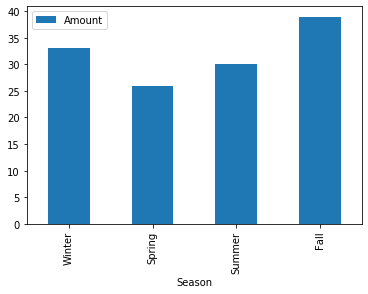

In [136]:
#simple plot for the bookings per season
seasons = {'Season':['Winter', 'Spring', 'Summer', 'Fall'],
        'Amount':[winter_duration_mean, spring_duration_mean, summer_duration_mean , fall_duration_mean]}
seasons = pd.DataFrame(seasons)
seasons['Amount']  = round(seasons['Amount'].dt.total_seconds()/60)
seasons.plot('Season', kind='bar')

# Routes

In [137]:
booking_set_frankfurt.dropna() #remove NaN because those lines won't give us anything here

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
17,21367245,50000,108136,52F601C735727653A8113E8AD5AC52E3BF89B492,2014-01-01 02:34:11,2014-01-01 02:34:11,2014-01-01 02:55:57,Nein,Nein,0.0,Carlo-Schmidt-Platz / Depot,214448.0,Rosa-Luxemburg-Straße / Ginnheimer Landstraße,231648.0,Standort,Frankfurt am Main,IVR
1706,21367386,50000,116907,5FB15874F8482B96D738225F24B27D4511A56D12,2014-01-01 03:07:37,2014-01-01 03:07:37,2014-01-01 03:15:13,Nein,Nein,0.0,Taunusstraße / Gallusanlage,28951.0,Opernplatz / Bockenheimer Landstaße,214376.0,Standort,Frankfurt am Main,IVR
340,21367759,50000,116510,5463C4A315BB2D2E0840FC24238727EDF6A8543B,2014-01-01 04:34:30,2014-01-01 04:34:30,2014-01-01 04:45:11,Nein,Nein,0.0,Dormero-Hotel / Europaallee,7596.0,Studierendenhaus Jügelstraße / Mertonstraße,23722.0,Standort,Frankfurt am Main,IVR
3093,21371429,50000,116614,C7478B24D91919C541442924123C8A21C07C950E,2014-01-01 20:19:22,2014-01-01 20:19:22,2014-01-01 20:35:28,Nein,Nein,0.0,Roßmarkt / An der Hauptwache,214380.0,Roßmarkt / An der Hauptwache,214380.0,Standort,Frankfurt am Main,IVR
3662,21372159,50000,116401,A9604235543BC897F7D19CE46C73E867DE58F4F5,2014-01-02 05:15:28,2014-01-02 05:15:28,2014-01-02 05:49:29,Nein,Nein,0.0,Leonardo-da-Vinci-Allee / Am Römerhof,226256.0,Pfarrer-Perabo-Platz / Kleyerstraße,214454.0,Standort,Frankfurt am Main,Android CAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16227459,46386545,50000,164398,6242697E27DA067976F613CF1C277DD3106B3F7F,2017-05-16 08:03:16,2017-05-16 08:03:16,2017-05-16 08:08:35,Ja,Nein,0.0,Haltestelle Rennbahn,254658.0,Universitätsklinikum Parkhaus / Sandhofstraße,232342.0,Standort,Frankfurt am Main,iPhone CAB
16227836,46386553,50000,165797,C46839DD56DD6098F79972E42F2A88AC9201B372,2017-05-16 08:03:26,2017-05-16 08:03:26,2017-05-16 08:11:02,Ja,Nein,0.0,Ludwigstraße / Niddastraße,257268.0,Adlerwerke Kleyerstrasse / Kriegkstrasse,214455.0,Standort,Frankfurt am Main,Android CAB
16228198,46386568,50000,163968,1D5AA97408E7303CB1DBEE06CBD8E64E074C1EC2,2017-05-16 08:03:47,2017-05-16 08:03:47,2017-05-16 08:09:46,Ja,Nein,0.0,Ackermannstraße / Cordierstraße,250938.0,Adlerwerke Kleyerstrasse / Kriegkstrasse,214455.0,Standort,Frankfurt am Main,iPhone CAB
16226977,46386569,50000,164846,B1DB7A4BCA9FD67122EDF740238F7D55C8BE4BE5,2017-05-16 08:03:47,2017-05-16 08:03:47,2017-05-16 08:08:04,Ja,Nein,0.0,Ludwigstraße / Niddastraße,257268.0,DB Rent-Zentrale / Mainzer Landstr. 169,227495.0,Standort,Frankfurt am Main,Android CAB


In [138]:
#use vehicle hal id to see how many vehicles are at one station at a time 
booking_set_frankfurt['VEHICLE_HAL_ID'].nunique()

3765

In [139]:
booking_set_frankfurt['VEHICLE_HAL_ID'].unique() #gives out the vehicle ids in array form 

array([115939, 116954, 119442, ..., 143849, 116546, 116745], dtype=int64)

In [140]:
#again change to the required dates
booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True) #sort the data after the date, ascending
booking_set_frankfurt['DATE_BOOKING'] = pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'])
booking_set_frankfurt['DATE_BOOKING'].dt.strftime('%Y-%m-%d %X')
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]

In [141]:
#set again a new table for the routes
booking_set_frankfurt_20152016['year'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%Y')
booking_set_frankfurt_20152016['month'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%b')
booking_set_frankfurt_20152016['date'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%d')
booking_set_frankfurt_20152016['hour'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%H')
booking_set_frankfurt_20152016['Day_of_week'] = booking_set_frankfurt_20152016['DATE_BOOKING'].dt.strftime('%a')

In [142]:
booking_set_frankfurt_20152016

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL,year,month,date,hour,Day_of_week
4284612,27689006,50000,110326,94E208715C9AA8B3258F2CF2BCF421FE059DFAAA,2015-01-01 00:21:22,2015-01-01 00:21:22,2015-01-01 00:25:18,Nein,Nein,0.0,Speyerer Straße / Koblenzer Straße,227726.0,NaN,12635.0,Standort,Frankfurt am Main,iPhone CAB,2015,Jan,01,00,Thu
4285336,27689041,50000,115667,0284A643498771058AA8BB3555DF8828D6D08635,2015-01-01 00:30:20,2015-01-01 00:30:20,2015-01-01 00:41:52,Nein,Nein,0.0,Roßmarkt / An der Hauptwache,214380.0,Beethovenstraße / Beethovenplatz,214393.0,Standort,Frankfurt am Main,IVR,2015,Jan,01,00,Thu
4285873,27689080,50000,116175,E2F878900ACA546F5D3DD11D7DCFF761D205B7BE,2015-01-01 00:42:51,2015-01-01 00:42:51,2015-01-01 01:08:49,Nein,Nein,0.0,Woolworth Leipziger Strasse,226253.0,Im Prüfling / Throner Straße,231602.0,Standort,Frankfurt am Main,Android CAB,2015,Jan,01,00,Thu
4286542,27689151,50000,110256,4BFADBFCF0460E0B9517D8769FE3610099585392,2015-01-01 01:00:19,2015-01-01 01:00:19,2015-01-01 01:11:19,Nein,Nein,0.0,Markus-Krankenhaus,227460.0,Eschersheimer Landstraße / Hügelstraße,214402.0,Standort,Frankfurt am Main,iPhone CAB,2015,Jan,01,01,Thu
4286567,27689154,50000,116123,0DA7FC2ECDEE84F51E8D498A8126BE2DE209993E,2015-01-01 01:00:47,2015-01-01 01:00:47,2015-01-01 01:11:20,Nein,Nein,0.0,Markus-Krankenhaus,227460.0,Eschersheimer Landstraße / Hügelstraße,214402.0,Standort,Frankfurt am Main,Android CAB,2015,Jan,01,01,Thu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14613160,43561784,50000,165502,9F30DD1C0D061AB3577ADD1BC0C1360CAC3702D1,2016-12-31 23:13:00,2016-12-31 23:13:00,2017-01-02 08:21:32,Nein,Nein,0.0,Hauptbahnhof Haupteingang (Vorplatz),214419.0,Hauptbahnhof Haupteingang (Vorplatz),214419.0,Standort,Frankfurt am Main,iPhone CAB,2016,Dec,31,23,Sat
14613511,43561828,50000,164856,CDA293642336D184957723DFFD87734B5E6F2CDB,2016-12-31 23:23:28,2016-12-31 23:23:28,2016-12-31 23:45:59,Nein,Nein,0.0,Taunusstraße / Gallusanlage,28951.0,OLG (Zeil / Oberlandesgericht),226348.0,Standort,Frankfurt am Main,iPhone CAB,2016,Dec,31,23,Sat
14612056,43561832,50000,164045,F440BA12F43719BB5E61ED1E59465716A0D5C6C0,2016-12-31 23:24:03,2016-12-31 23:24:03,2016-12-31 23:32:50,Nein,Nein,0.0,Sternstraße / Unterweg,257334.0,Röderbergweg,254285.0,Standort,Frankfurt am Main,Android CAB,2016,Dec,31,23,Sat
14615815,43561863,50000,165498,EEC46612DCC24C28400BF399C4D9C7BB1D1C69C8,2016-12-31 23:28:04,2016-12-31 23:28:04,2016-12-31 23:33:25,Nein,Nein,0.0,Sternstraße / Unterweg,257334.0,Eschersheimer Landstraße / Grüneburgweg,227484.0,Standort,Frankfurt am Main,iPhone CAB,2016,Dec,31,23,Sat


In [143]:
#select the columns that you need for the start station
booking_vehicle_start = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE', 'START_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID', 'Day_of_week', 'hour']]

In [144]:
booking_vehicle_start

,BOOKING_HAL_ID,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,VEHICLE_HAL_ID,Day_of_week,hour
4284612,27689006,Speyerer Straße / Koblenzer Straße,227726.0,110326,Thu,00
4285336,27689041,Roßmarkt / An der Hauptwache,214380.0,115667,Thu,00
4285873,27689080,Woolworth Leipziger Strasse,226253.0,116175,Thu,00
4286542,27689151,Markus-Krankenhaus,227460.0,110256,Thu,01
4286567,27689154,Markus-Krankenhaus,227460.0,116123,Thu,01
...,...,...,...,...,...,...
14613160,43561784,Hauptbahnhof Haupteingang (Vorplatz),214419.0,165502,Sat,23
14613511,43561828,Taunusstraße / Gallusanlage,28951.0,164856,Sat,23
14612056,43561832,Sternstraße / Unterweg,257334.0,164045,Sat,23
14615815,43561863,Sternstraße / Unterweg,257334.0,165498,Sat,23


In [145]:
booking_vehicle_start_two = booking_vehicle_start.groupby(["START_RENTAL_ZONE", "Day_of_week"], as_index = False)['VEHICLE_HAL_ID'].count()

In [146]:
booking_vehicle_start_two

,START_RENTAL_ZONE,Day_of_week,VEHICLE_HAL_ID
0,Ackermannstraße / Cordierstraße,Fri,124
1,Ackermannstraße / Cordierstraße,Mon,113
2,Ackermannstraße / Cordierstraße,Sat,88
3,Ackermannstraße / Cordierstraße,Sun,93
4,Ackermannstraße / Cordierstraße,Thu,107
...,...,...,...
2244,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Sat,96
2245,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Sun,95
2246,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Thu,206
2247,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Tue,191


In [147]:
#select one of the stations and plot how many bikes there are over the course of the day 

### Amount of vehicles at the main train station for the different week days

In [148]:
#station to select: Hauptbahnhof Haupteingang (Vorplatz) 
vehicles_station = booking_vehicle_start_two[booking_vehicle_start_two['START_RENTAL_ZONE'].str.contains('Hauptbahnhof Haupteingang')]

In [149]:
vehicles_station

,START_RENTAL_ZONE,Day_of_week,VEHICLE_HAL_ID
1108,Hauptbahnhof Haupteingang (Vorplatz),Fri,10985
1109,Hauptbahnhof Haupteingang (Vorplatz),Mon,9963
1110,Hauptbahnhof Haupteingang (Vorplatz),Sat,7251
1111,Hauptbahnhof Haupteingang (Vorplatz),Sun,8258
1112,Hauptbahnhof Haupteingang (Vorplatz),Thu,11367
1113,Hauptbahnhof Haupteingang (Vorplatz),Tue,11223
1114,Hauptbahnhof Haupteingang (Vorplatz),Wed,11950


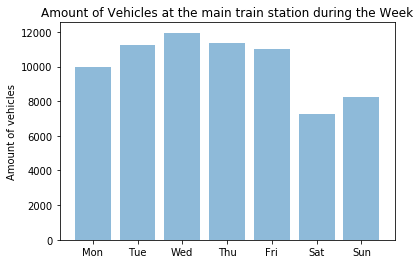

In [150]:
#als erstes wie viele sind über die Wochentage da als Plot
sorter = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sorterIndex = dict(zip(sorter,range(len(sorter))))
vehicles_station['Day_id'] = vehicles_station.index
vehicles_station['Day_id'] = vehicles_station['Day_of_week'].map(sorterIndex)
vehicles_station.sort_values('Day_id', inplace=True)
y_pos = np.arange(len(vehicles_station['Day_of_week']))
plt.bar(y_pos, vehicles_station['VEHICLE_HAL_ID'], align='center', alpha=0.5)
plt.xticks(y_pos, vehicles_station['Day_of_week'])
plt.ylabel('Amount of vehicles')
plt.title('Amount of Vehicles at the main train station during the Week')

plt.show()

In [151]:
#the main station is a transport node and a transition to train traffic
#the plot shows a specific survey for the central station in terms of how many journeys have started from the main station
#booking mean duration on weekdays are approximately similar, expect the weekend
#one can assume that during the week many employees arrive by train in Frankfurt and then cycle to work (and going back)
#at the weekend bikes may be used for private purposes, which is less in total

### Amount of vehicles that arrive/leave the main train station over the day

In [152]:
#Plot the amount of vehicles at this station over the day
booking_vehicle_start_three = booking_vehicle_start.groupby(["START_RENTAL_ZONE", "hour"], as_index = False)['VEHICLE_HAL_ID'].count()
vehicles_station_hour = booking_vehicle_start_three[booking_vehicle_start_three['START_RENTAL_ZONE'].str.contains('Hauptbahnhof Haupteingang')]
vehicles_station_hour

,START_RENTAL_ZONE,hour,VEHICLE_HAL_ID
3620,Hauptbahnhof Haupteingang (Vorplatz),00,1911
3621,Hauptbahnhof Haupteingang (Vorplatz),01,1974
3622,Hauptbahnhof Haupteingang (Vorplatz),02,1431
3623,Hauptbahnhof Haupteingang (Vorplatz),03,867
3624,Hauptbahnhof Haupteingang (Vorplatz),04,486
3625,Hauptbahnhof Haupteingang (Vorplatz),05,500
3626,Hauptbahnhof Haupteingang (Vorplatz),06,1743
3627,Hauptbahnhof Haupteingang (Vorplatz),07,6790
3628,Hauptbahnhof Haupteingang (Vorplatz),08,7803
3629,Hauptbahnhof Haupteingang (Vorplatz),09,3978


In [153]:
vehicles_station_hour['VEHICLE_HAL_ID'].sum()

70997

In [154]:
#now also get leaving bikes for the following plot
booking_vehicle_end = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'END_RENTAL_ZONE', 'END_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID', 'Day_of_week', 'hour']]
booking_vehicle_end_two = booking_vehicle_end.groupby(["END_RENTAL_ZONE", "hour"], as_index = False)['VEHICLE_HAL_ID'].count()
vehicles_station_hour_end = booking_vehicle_end_two[booking_vehicle_end_two['END_RENTAL_ZONE'].str.contains('Hauptbahnhof Haupteingang')]
vehicles_station_hour_end

,END_RENTAL_ZONE,hour,VEHICLE_HAL_ID
3690,Hauptbahnhof Haupteingang (Vorplatz),00,668
3691,Hauptbahnhof Haupteingang (Vorplatz),01,562
3692,Hauptbahnhof Haupteingang (Vorplatz),02,501
3693,Hauptbahnhof Haupteingang (Vorplatz),03,420
3694,Hauptbahnhof Haupteingang (Vorplatz),04,430
3695,Hauptbahnhof Haupteingang (Vorplatz),05,773
3696,Hauptbahnhof Haupteingang (Vorplatz),06,1814
3697,Hauptbahnhof Haupteingang (Vorplatz),07,2605
3698,Hauptbahnhof Haupteingang (Vorplatz),08,2811
3699,Hauptbahnhof Haupteingang (Vorplatz),09,2139


In [155]:
vehicles_station_hour_end['VEHICLE_HAL_ID'].sum()

70728

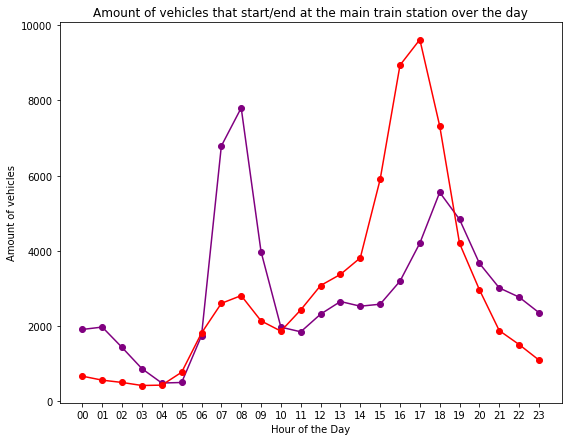

In [156]:
#this plot shows the bikes at the main train station that are leaving in violet and that are arriving in red
# Create the plot space upon which to plot the data 
fig, ax = plt.subplots(figsize=(9, 7))

# Add the x-axis and the y-axis to the plot
ax.plot(vehicles_station_hour['hour'],
        vehicles_station_hour['VEHICLE_HAL_ID'], '-o',
        color='purple')

ax.plot(vehicles_station_hour_end['hour'],
        vehicles_station_hour_end['VEHICLE_HAL_ID'], '-o',
        color='red')
# Set title and labels for axes
ax.set(xlabel="Hour of the Day",
       ylabel="Amount of vehicles",
       title="Amount of vehicles that start/end at the main train station over the day")
plt.show()

In [157]:
#in contrast to the general representation at what time of the day how many bikes are rented, a distinction is made here between start- and ending at the main station.
#one can see that an extremely large number of bikes start in the morning and just as many bikes arrive in the evening
#again regarding the normal working hours of employees, keyword 'rushhour'
#this confirms the assumption that many customers rent bicycles to get to work and come back

In [158]:
#now these are total amounts lets see what the mean says

### the mean of vehicles that start/end among all stations over the day

In [159]:
vehicle_start_count = booking_vehicle_start.groupby(["START_RENTAL_ZONE", "hour"], as_index = False)['VEHICLE_HAL_ID'].count()
vehicle_start_count

,START_RENTAL_ZONE,hour,VEHICLE_HAL_ID
0,Ackermannstraße / Cordierstraße,00,7
1,Ackermannstraße / Cordierstraße,01,3
2,Ackermannstraße / Cordierstraße,02,3
3,Ackermannstraße / Cordierstraße,03,6
4,Ackermannstraße / Cordierstraße,04,4
...,...,...,...
7433,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,19,75
7434,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,20,60
7435,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,21,29
7436,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,22,21


In [160]:
vehicle_start_mean = vehicle_start_count.groupby(["hour"], as_index = False)['VEHICLE_HAL_ID'].mean()
vehicle_start_mean['VEHICLE_HAL_ID']  = round(vehicle_start_mean['VEHICLE_HAL_ID']) #rude Werte
vehicle_start_mean

,hour,VEHICLE_HAL_ID
0,00,69.0
1,01,62.0
2,02,46.0
3,03,32.0
4,04,20.0
5,05,23.0
6,06,55.0
7,07,192.0
8,08,324.0
9,09,203.0


In [161]:
#same for end
vehicle_end_count = booking_vehicle_end.groupby(["END_RENTAL_ZONE", "hour"], as_index = False)['VEHICLE_HAL_ID'].count()
vehicle_end_count

,END_RENTAL_ZONE,hour,VEHICLE_HAL_ID
0,Ackermannstraße / Cordierstraße,00,13
1,Ackermannstraße / Cordierstraße,01,16
2,Ackermannstraße / Cordierstraße,02,14
3,Ackermannstraße / Cordierstraße,03,9
4,Ackermannstraße / Cordierstraße,04,9
...,...,...,...
7502,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,19,66
7503,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,20,52
7504,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,21,41
7505,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,22,19


In [162]:
vehicle_end_mean = vehicle_end_count.groupby(["hour"], as_index = False)['VEHICLE_HAL_ID'].mean()
vehicle_end_mean['VEHICLE_HAL_ID']  = round(vehicle_end_mean['VEHICLE_HAL_ID']) 
vehicle_end_mean

,hour,VEHICLE_HAL_ID
0,00,69.0
1,01,62.0
2,02,46.0
3,03,31.0
4,04,19.0
5,05,22.0
6,06,58.0
7,07,195.0
8,08,326.0
9,09,201.0


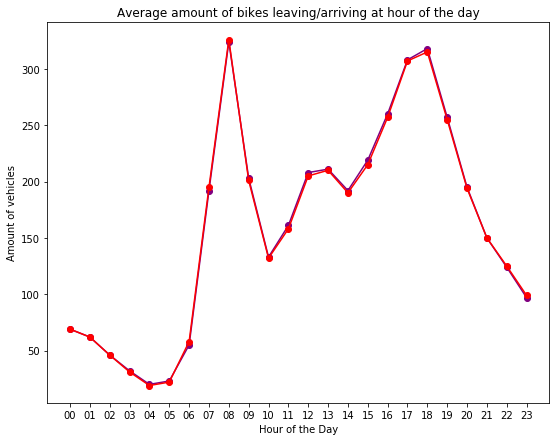

In [163]:
# Create the plot space upon which to plot the data 
fig, ax = plt.subplots(figsize=(9, 7))

# Add the x-axis and the y-axis to the plot
ax.plot(vehicle_start_mean['hour'],
        vehicle_start_mean['VEHICLE_HAL_ID'], '-o',
        color='purple')

ax.plot(vehicle_end_mean['hour'],
        vehicle_end_mean['VEHICLE_HAL_ID'], '-o',
        color='red')
# Set title and labels for axes
ax.set(xlabel="Hour of the Day",
       ylabel="Amount of vehicles",
       title="Average amount of bikes leaving/arriving at hour of the day")
plt.show()

In [164]:
#we see that this plot is not relevant since the mean duration of the bookings is under an hour
#however we might look at a specific time interval closer

### Amount of vehicles that leave/start at the main train station between 7 and 10 am

In [165]:
booking_vehicle_start = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE', 'START_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID', 'DATE_BOOKING']]

In [166]:
booking_vehicle_start

,BOOKING_HAL_ID,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,VEHICLE_HAL_ID,DATE_BOOKING
4284612,27689006,Speyerer Straße / Koblenzer Straße,227726.0,110326,2015-01-01 00:21:22
4285336,27689041,Roßmarkt / An der Hauptwache,214380.0,115667,2015-01-01 00:30:20
4285873,27689080,Woolworth Leipziger Strasse,226253.0,116175,2015-01-01 00:42:51
4286542,27689151,Markus-Krankenhaus,227460.0,110256,2015-01-01 01:00:19
4286567,27689154,Markus-Krankenhaus,227460.0,116123,2015-01-01 01:00:47
...,...,...,...,...,...
14613160,43561784,Hauptbahnhof Haupteingang (Vorplatz),214419.0,165502,2016-12-31 23:13:00
14613511,43561828,Taunusstraße / Gallusanlage,28951.0,164856,2016-12-31 23:23:28
14612056,43561832,Sternstraße / Unterweg,257334.0,164045,2016-12-31 23:24:03
14615815,43561863,Sternstraße / Unterweg,257334.0,165498,2016-12-31 23:28:04


In [167]:
booking_vehicle_start['time'] = booking_vehicle_start['DATE_BOOKING'].dt.strftime('%X')

In [168]:
booking_vehicle_start

,BOOKING_HAL_ID,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,VEHICLE_HAL_ID,DATE_BOOKING,time
4284612,27689006,Speyerer Straße / Koblenzer Straße,227726.0,110326,2015-01-01 00:21:22,00:21:22
4285336,27689041,Roßmarkt / An der Hauptwache,214380.0,115667,2015-01-01 00:30:20,00:30:20
4285873,27689080,Woolworth Leipziger Strasse,226253.0,116175,2015-01-01 00:42:51,00:42:51
4286542,27689151,Markus-Krankenhaus,227460.0,110256,2015-01-01 01:00:19,01:00:19
4286567,27689154,Markus-Krankenhaus,227460.0,116123,2015-01-01 01:00:47,01:00:47
...,...,...,...,...,...,...
14613160,43561784,Hauptbahnhof Haupteingang (Vorplatz),214419.0,165502,2016-12-31 23:13:00,23:13:00
14613511,43561828,Taunusstraße / Gallusanlage,28951.0,164856,2016-12-31 23:23:28,23:23:28
14612056,43561832,Sternstraße / Unterweg,257334.0,164045,2016-12-31 23:24:03,23:24:03
14615815,43561863,Sternstraße / Unterweg,257334.0,165498,2016-12-31 23:28:04,23:28:04


In [169]:
booking_vehicle_start_2 = booking_vehicle_start.drop('DATE_BOOKING', axis=1)

In [170]:
booking_vehicle_start_3 = booking_vehicle_start_2.groupby(["START_RENTAL_ZONE", "time"], as_index = False)['VEHICLE_HAL_ID'].count()
vehicles_station_4 = booking_vehicle_start_3[booking_vehicle_start_3['START_RENTAL_ZONE'].str.contains('Hauptbahnhof Haupteingang')]
vehicles_station_4

,START_RENTAL_ZONE,time,VEHICLE_HAL_ID
511383,Hauptbahnhof Haupteingang (Vorplatz),00:00:03,1
511384,Hauptbahnhof Haupteingang (Vorplatz),00:00:09,1
511385,Hauptbahnhof Haupteingang (Vorplatz),00:00:15,1
511386,Hauptbahnhof Haupteingang (Vorplatz),00:00:19,1
511387,Hauptbahnhof Haupteingang (Vorplatz),00:00:21,1
...,...,...,...
554830,Hauptbahnhof Haupteingang (Vorplatz),23:59:50,1
554831,Hauptbahnhof Haupteingang (Vorplatz),23:59:51,1
554832,Hauptbahnhof Haupteingang (Vorplatz),23:59:52,1
554833,Hauptbahnhof Haupteingang (Vorplatz),23:59:54,2


In [171]:
start = '07:00:00'
end = '10:00:00'
filters = (vehicles_station_4['time'] >= start) & (vehicles_station_4['time'] <= end)
vehicles_station_5 = vehicles_station_4.loc[filters]

In [172]:
vehicles_station_5

,START_RENTAL_ZONE,time,VEHICLE_HAL_ID
518309,Hauptbahnhof Haupteingang (Vorplatz),07:00:03,3
518310,Hauptbahnhof Haupteingang (Vorplatz),07:00:04,1
518311,Hauptbahnhof Haupteingang (Vorplatz),07:00:07,1
518312,Hauptbahnhof Haupteingang (Vorplatz),07:00:08,1
518313,Hauptbahnhof Haupteingang (Vorplatz),07:00:10,1
...,...,...,...
526612,Hauptbahnhof Haupteingang (Vorplatz),09:59:54,1
526613,Hauptbahnhof Haupteingang (Vorplatz),09:59:56,1
526614,Hauptbahnhof Haupteingang (Vorplatz),09:59:57,1
526615,Hauptbahnhof Haupteingang (Vorplatz),09:59:59,1


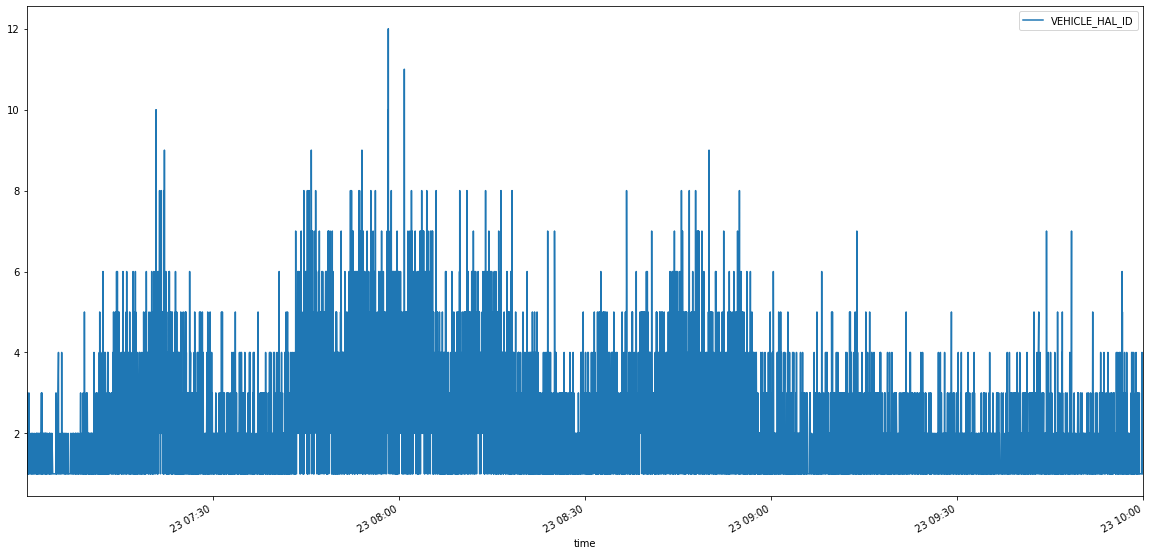

In [173]:
vehicles = vehicles_station_5.drop('START_RENTAL_ZONE', axis=1)
vehicles['time'] = pd.to_datetime(vehicles['time'])
vehicles2 = vehicles.set_index('time')
vehicles2.plot(figsize=(20,10))


### Routes/Stations - Often used vs seldomly used

In [174]:
#select the columns that you need for the end station
booking_vehicle_end = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'END_RENTAL_ZONE', 'END_RENTAL_ZONE_HAL_ID', 'Day_of_week', 'hour']]

In [175]:
#see the distribution of stations 
start_stations_busy = booking_set_frankfurt_20152016.groupby(booking_set_frankfurt_20152016['START_RENTAL_ZONE'], as_index=False).size()

In [176]:
start_stations_busy.nlargest(10)

START_RENTAL_ZONE
Hauptbahnhof Haupteingang (Vorplatz)            70997
Hauptbahnhof / Taxistand                        26816
Konstablerwache                                 24484
Pfarrer-Perabo-Platz / Kleyerstraße             23920
Campus Westend Hörsaalzentrum                   23797
Opernplatz / Bockenheimer Landstaße             20264
Carlo-Schmidt-Platz  / Depot                    20125
Roßmarkt / An der Hauptwache                    18853
Bockenheimer Landstraße / Liebigstraße          17982
Jürgen-Ponto-Platz / Neckarstraße (DB-Tower)    16881
dtype: int64

In [177]:
start_stations_busy.nsmallest(10)

START_RENTAL_ZONE
Commerzbank DLZ                          1
Commerzbankhochhaus                      1
BSC Repeater                             2
Commerzbank Gallileo                     9
Bechtenwaldstraße / Hahnbergweg         30
S-Bahn Station Farbwerke                37
BSC Grafittihalle                       48
Hans-Böckler-Straße / Geißspitzweg      50
Sindlinger Bahnstraße / Farbenstraße    59
Bahnhof Bieber / Poststraße             62
dtype: int64

In [178]:
#let's check the most used actual routes that we have, not just start and end stations, but the combinations of both
routes = booking_set_frankfurt.groupby(['START_RENTAL_ZONE','END_RENTAL_ZONE']).size().reset_index().rename(columns={0:'count'})
routes

,START_RENTAL_ZONE,END_RENTAL_ZONE,count
0,Ackermannstraße / Cordierstraße,Ackermannstraße / Cordierstraße,135
1,Ackermannstraße / Cordierstraße,Ackermannstraße / Kleyerstraße,2
2,Ackermannstraße / Cordierstraße,Adam-Riese-Platz / Hafenstraße,3
3,Ackermannstraße / Cordierstraße,Adlerwerke Kleyerstrasse / Kriegkstrasse,9
4,Ackermannstraße / Cordierstraße,Affentorplatz,1
...,...,...,...
50922,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Wiesenhüttenplatz,2
50923,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Wilhelm-Leuschner-Straße/ Windmühlstraße,5
50924,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Woolworth Leipziger Strasse,3
50925,zzz4 vormals Sandhofschleife / Paul-Ehrlich-St...,Ziegelhüttenplatz / Ziegelhüttenweg,15


In [179]:
routes.sort_values(by=['count'])

,START_RENTAL_ZONE,END_RENTAL_ZONE,count
25463,Idsteiner Straße / Schneidhainer Straße,Mannheimer Straße / Stuttgarter Straße,1
38731,Ruth-Mufang-Straße / Riedbergallee,Nußzeil / Josephskirchstraße,1
38729,Ruth-Mufang-Straße / Riedbergallee,Messe Haupteingang / Friedrich-Ebert-Anlage,1
38726,Ruth-Mufang-Straße / Riedbergallee,Markgrafenstraße / Leipziger Straße,1
38724,Ruth-Mufang-Straße / Riedbergallee,Leonardo-da-Vinci-Allee / Am Römerhof,1
...,...,...,...
35933,Pfarrer-Perabo-Platz / Kleyerstraße,Hauptbahnhof Haupteingang (Vorplatz),5269
24463,Hauptbahnhof Haupteingang (Vorplatz),Hauptbahnhof Haupteingang (Vorplatz),5751
35996,Pfarrer-Perabo-Platz / Kleyerstraße,S-Bahn Station Galluswarte / Mainzer Landstraße,5913
24234,Hauptbahnhof / Taxistand,Pfarrer-Perabo-Platz / Kleyerstraße,6861


# Clustering
## Preparation

In [180]:
#reading in data and prepare for Frankfurt 2015 and 2016
#just clustering on both years, no separate clustering since it does not seem useful

We are going to cluster the stations first. Station names and IDs would just appear as index, hence data points in a cluster, still they would be added together for all NaN in one cluster. We do not know what NaN means for certain stations. Did it mean that the station simply wasn't added to the data or that the bike isn't at a specific station? Since we cannot know this for sure, we will drop all the rows with NaN values.

In [181]:
# 1. read data
# 2. drop NaN values
# 3. split for Frankfurt
# 4. split for right timing
# 5. change other date formats 
# 6. add duration column
#booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", delimiter=';')
booking_set = booking_set.dropna()

In [182]:
booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]

In [183]:
booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True) #sort the data after the date, ascending
booking_set_frankfurt['DATE_BOOKING'] = pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'])
booking_set_frankfurt['DATE_BOOKING'].dt.strftime('%Y-%m-%d %X')
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]

In [184]:
booking_set_frankfurt_20152016['DATE_UNTIL'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_UNTIL'])
booking_set_frankfurt_20152016['DATE_UNTIL'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['DATE_FROM'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_FROM'])
booking_set_frankfurt_20152016['DATE_FROM'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['duration'] = booking_set_frankfurt_20152016['DATE_UNTIL'] - booking_set_frankfurt_20152016['DATE_FROM']


## Cluster stations by customer types

### Preparation

In [185]:
#check how many unique ustomers a station has
#make two columns, one with the amount of customers a station that has over 100 bookings for that station
#and one with the rest of customers that has under 100 bookings
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]
a = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].count()
a2 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
c = a.loc[a['BOOKING_HAL_ID'] > 100]

In [186]:
c2 = c.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
c2 = c2.rename(columns={"CUSTOMER_HAL_ID" : "over_100_bookings"})
a2 = a2.set_index('START_RENTAL_ZONE_HAL_ID')
c2 = c2.set_index('START_RENTAL_ZONE_HAL_ID')

In [187]:
result = pd.concat([a2, c2], axis=1)
result.fillna(0, inplace=True)

In [188]:
result['under_100_bookings'] = result['CUSTOMER_HAL_ID'] - result['over_100_bookings']
result = result.drop('CUSTOMER_HAL_ID', axis=1)                                                   

In [189]:
#remove outliers
indexNames = result[ result['over_100_bookings'] > 40 ].index
indexNames
result = result.drop(indexNames)


### K-Means

In [190]:
#scale values
scaler = StandardScaler()
scaler.fit(result)
X_scaled = scaler.transform(result)
X_scaled_df = pd.DataFrame(X_scaled, columns=result.columns, index=result.index)
X_scaled_df.head()

,over_100_bookings,under_100_bookings
START_RENTAL_ZONE_HAL_ID,,
3710.0,-0.224552,-0.356550
3717.0,-0.526146,-0.618293
3916.0,-0.224552,0.640325
3954.0,-0.224552,0.123995
3961.0,-0.526146,3.058384


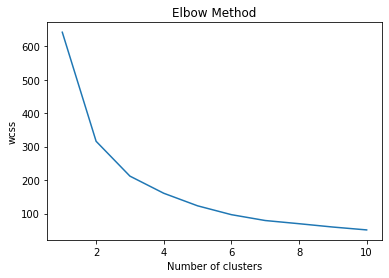

In [191]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

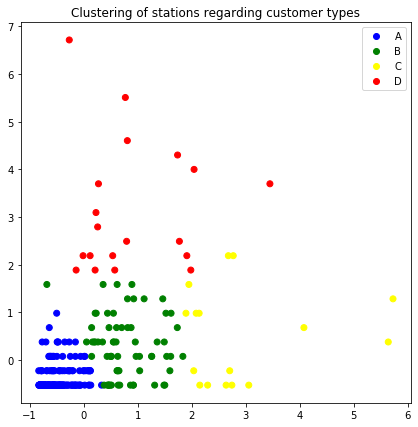

In [192]:
#plot the k-means
classes = ['A', 'B', 'C', 'D']
colours = ListedColormap(["blue", "green", "yellow", "red"])

means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
scatter = plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=x_pred, cmap=colours)
plt.title("Clustering of stations regarding customer types")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.show()

Here 4 Clusters (possible up to 6):
- green: small size of regular and occasional customers 
- yellow: medium to big size of regular customers with up to medium occasional
- red: medium size of regular customers, small to medium size of occasional customers
- blue: small size of regular customers, medium to big size occasional customers


### Result: 

After testing all three clustering algorithms, K-Means had the best result, hence remains.

### Explanation: 

The stations with little occasional customers and many permanent ones, are probably going to schools or areas with working places where there is no need to go to on occasion since eg. shopping center etc is missing. Whereas the other way around with many occasional customers are places where not many are going often, eg shopping centers or parks etc. The outliers should be looked at separately, but again it is most likely train stations. What would be a senseful cluster number-wise?

## Cluster the stations by amount of bookings and hour

Let's think about what actually makes sense to cluster stations for? Would the duration make sense as an attribute for a station? Problably not. Monthly rentals might reduce over time with bad weather but hourly data could still make a difference. How many bookings and vehicles are on the stations over the day? This will most likely produce another linear outcome, but maybe it will point something out.

### Preparation

In [193]:
#cluster the statuons with amount of bookings during the hour
#to prevent the multiple listing of unique stations, just choose the hour where the station had the highest
#amount of bookings 
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID', 'DATE_BOOKING']]
cluster['hour'] = cluster['DATE_BOOKING'].dt.strftime('%H')

In [194]:
second_cluster = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'hour'], as_index = False)['BOOKING_HAL_ID'].count()
second_cluster = second_cluster.rename(columns={"START_RENTAL_ZONE_HAL_ID": "id"})
second_cluster = second_cluster.rename(columns={"BOOKING_HAL_ID": "amount"})

In [195]:
indices = second_cluster.groupby('id')['amount'].idxmax
second_cluster = second_cluster.loc[indices]
second_cluster = second_cluster.set_index('id')
second_cluster = second_cluster.sort_values(by='hour')

In [196]:
#drop the outliers with over 4000 bookings
indexNames = second_cluster[ second_cluster['amount'] > 4000 ].index
indexNames
second_cluster = second_cluster.drop(indexNames)
second_cluster

,hour,amount
id,,
252298.0,00,21
250934.0,00,24
254653.0,00,16
258998.0,05,26
232598.0,07,429
...,...,...
227471.0,21,123
250669.0,22,268
231638.0,22,93


### K-Means

In [197]:
#scale values
scaler = StandardScaler()
scaler.fit(second_cluster)
X_scaled = scaler.transform(second_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=second_cluster.columns, index=second_cluster.index)
X_scaled_df.head()

,hour,amount
id,,
252298.0,-2.542524,-0.764249
250934.0,-2.542524,-0.757553
254653.0,-2.542524,-0.775410
258998.0,-1.540867,-0.753088
232598.0,-1.140204,0.146466


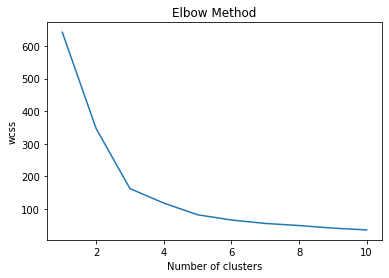

In [198]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

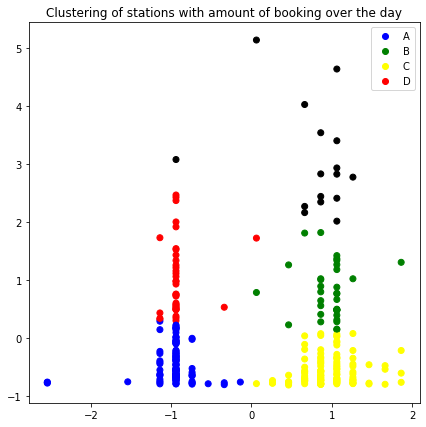

In [199]:
#plot the k-means

classes = ['A', 'B', 'C', 'D', 'E']
colours = ListedColormap(["blue", "green", "yellow", "red", "black"])

means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("Clustering of stations with amount of booking over the day")

plt.show()




### Hierarchical Clustering

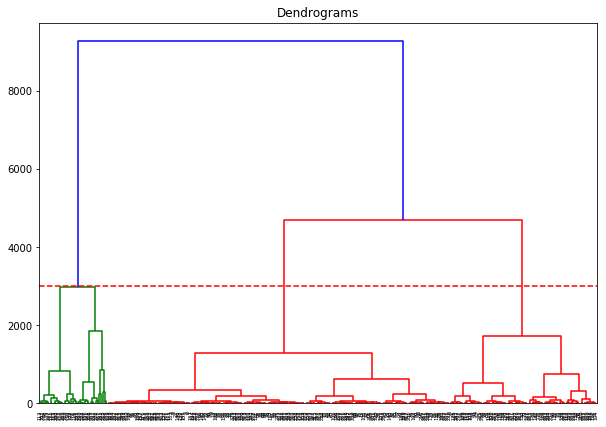

In [200]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(second_cluster, method='ward'))
plt.axhline(y=3000, color='r', linestyle='--')

In [201]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(second_cluster)

array([2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 3, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1,
       1, 1, 2, 2, 3, 1, 2, 3, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1,
       1, 3, 1, 3, 1, 3, 1, 2, 1, 3, 1, 2, 0, 0, 1, 0, 3, 1, 1, 1, 1, 2,
       1, 3, 3, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 1, 0, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 3, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 3, 1, 3, 3, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 1, 1, 2, 0, 3, 0, 1, 1, 2, 1,
       1, 2, 1, 2, 0, 3, 0, 2, 2, 2, 1, 2, 2, 2, 2,

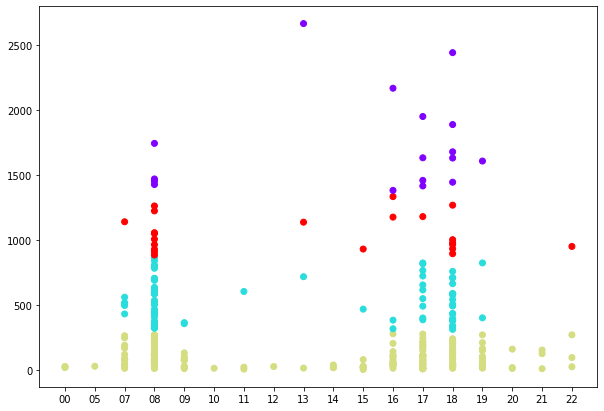

In [202]:
plt.figure(figsize=(10, 7))
plt.scatter(second_cluster['hour'], second_cluster['amount'], c=cluster.labels_, cmap='rainbow')

### Result:

There are a lot of stations that have their highest of bookinf over the day, even though this is still a very low amount of bookings. There are again very few that have an unnaturally high amount. This falls into the time of the working hours, so might be a true result. It might as well be outliers though. Majority of clusters makes a break at around 1000 bookings and starts the second cluster until around 30000. After that just the "outliers" form a cluster. No cluster algorithm showed clusters in the sense of separating into different hour intervals, which might be a result of the distance metrics. However, it seems reasonable that most stations have their high point around the working hours. In between there are relatively few stations that have their highest point. 

Technically doesn't it make sense to seperate again into stations with small size, medium size and large size of customers for each morning till lunch and then afternoon and night? Maybe a destinction of stations used at night etc would have made more sense? 

### Explanation: 

Also here, it seems that k-means has the best clustering that makes sense. 4 clusters, one with few customers over the daytime, one with few customers in the afternoon, one with many customers over the daytime, one with many customers in the later hours.

## Stations with the amount of bookings and customers

###  Preparation

In [203]:
#get one cluster with the amount of bookings a station 
# one cluster with the amount of unique customers a station 
#combine those clusters to one table
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]
cluster4 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].count()
cluster4 = cluster4.set_index('START_RENTAL_ZONE_HAL_ID')

In [204]:
cluster5 = cluster.groupby(by='START_RENTAL_ZONE_HAL_ID', as_index=False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
cluster5 = cluster5.set_index('START_RENTAL_ZONE_HAL_ID')
cluster4 = cluster4.merge(cluster5, left_index=True, right_index=True)

In [205]:
#drop out the outliers with over 10000 customers
indexNames = cluster4[ cluster4['CUSTOMER_HAL_ID'] > 10000 ].index
indexNames
cluster4 = cluster4.drop(indexNames)

### K-Means

In [206]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster4)
X_scaled = scaler.transform(cluster4)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster4.columns, index=cluster4.index)
X_scaled_df.head()

,BOOKING_HAL_ID,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,-0.270326,-0.363853
3717.0,-0.569365,-0.623753
3916.0,0.233606,0.622149
3954.0,-0.267105,0.111451
3961.0,1.490710,3.012825


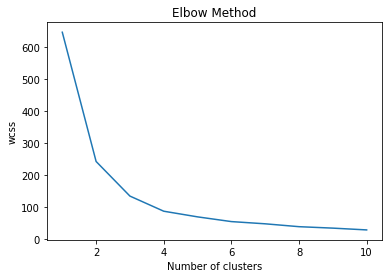

In [207]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

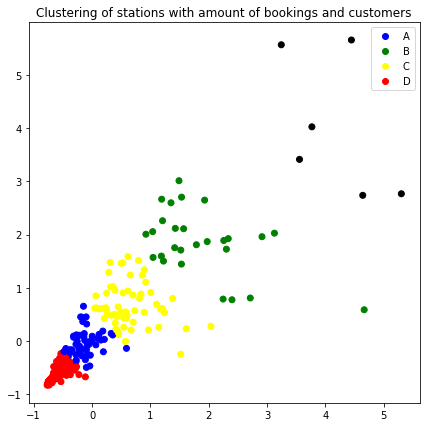

In [208]:
#plot the k-means
classes = ['A', 'B', 'C', 'D', 'E']
colours = ListedColormap(["blue", "green", "yellow", "red", "black"])

means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.title("Clustering of stations with amount of bookings and customers")

plt.show()

### Gaussian Mixture

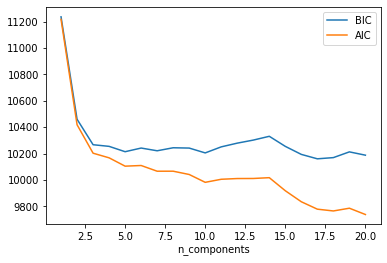

In [209]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster4)
          for n in n_components]

plt.plot(n_components, [m.bic(cluster4) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cluster4) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

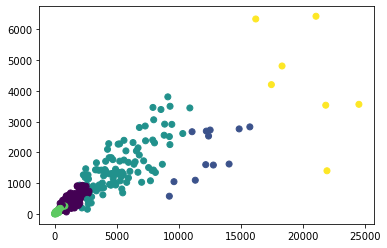

In [210]:
gmm = GaussianMixture(n_components=5).fit(cluster4)
labels = gmm.predict(cluster4)
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=labels, cmap='viridis')

###  Hierarchical Clustering

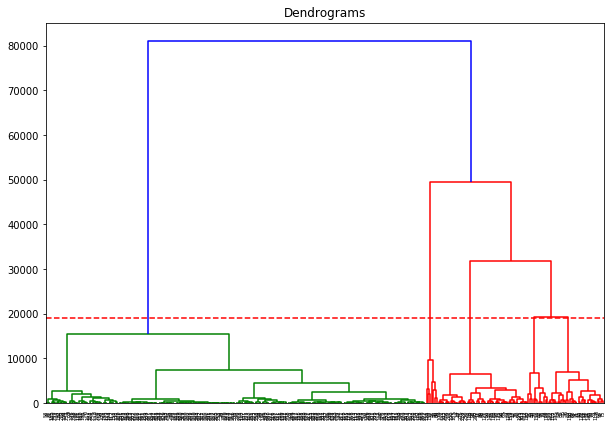

In [211]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(cluster4, method='ward'))
plt.axhline(y=19000, color='r', linestyle='--')
#we could also place the line further up and make it less clusters

In [212]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')  
cluster.fit_predict(cluster4)

array([4, 4, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1,
       1, 4, 4, 2, 4, 1, 4, 4, 1, 1, 2, 4, 4, 1, 4, 0, 4, 2, 2, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 1, 2, 1, 0, 1,
       1, 2, 3, 2, 2, 1, 1, 2, 1, 1, 4, 1, 1, 2, 1, 4, 4, 1, 1, 1, 4, 4,
       4, 1, 1, 4, 4, 1, 4, 1, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 1, 4, 1, 4, 2, 4, 4, 1, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4,
       4, 3, 2, 3, 4, 1, 4, 4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Text(0.5, 1.0, 'Clstering of Stations for Bookings and Customers')

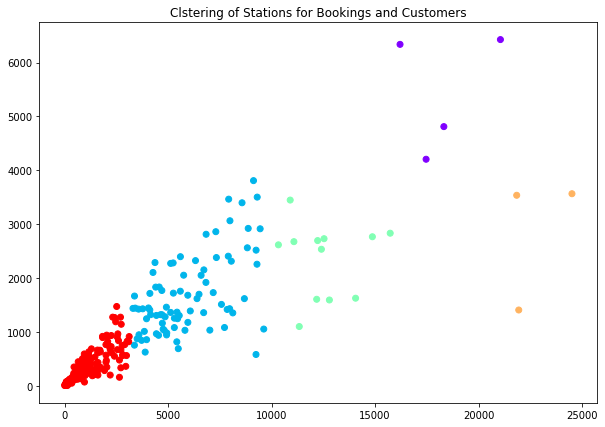

In [213]:
#plot the HC
plt.figure(figsize=(10, 7))
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=cluster.labels_, cmap='rainbow')
plt.title("Clstering of Stations for Bookings and Customers")

### Result: 

There is one cluster with very little customers and bookings, the lines are roughly 2000 customer and 4000 bookings. Another cluster has a wider area but still more customers, the lines are roughly 17000 bookings and 4000 customers. Then the next cluster has barely any stations but still a few. The lines are wide. There are those that have relatively little bookings but many customers and the other way around, little customers but many bookings. Then again there is one station that is far away from all others and makes it own cluster with many bookings and many customers. 

The HC seems the most accurate: 
- Cluster 1: small size of bookingd and customers
- Cluster 2: medium size of bookings and customers
- Cluster 3: higher amount of bookings than Cluster 2
- Cluster 4: high amount of bookings and customers
- Cluster 5: high amount of bookings and medium amount of customers

### Explanation: 

Most likely, the first cluster with very few customers and bookings are stations that aren't used very often. The next cluster with a higher variance, sometimes relatively much bookings with a few customers might be those stations that are used by customers going to work or school, also possible would be shopping centers etc. that are often used. Then next clusters are most probably those that go to very specific places, e.g. a train station. It might be possible to find more information when we see when these stations are accessed. 

- After removal of the one outlier:
The last HC cluster seems to make enough sense with 5 clusters.
- red: stations with few customers and bookings
- blue: stations with medium customers and bookings
- mint: stations with medium customers and many bookings
- violet: stations with many customers and many bookings
- stations with medium customers and the most bookings

# Clusters with the weather data

## Cluster the amount of bookings to the temperature

### Preparation

In [214]:
#read in weather data and cluster the amount of rentals per temperature
booking_set2 = pd.read_csv("DataBase_WeatherRentalAmountStations_UTC.csv")
bookings_temp = booking_set2.groupby(['Temperature'], as_index = False)['Rentals'].sum()

### K-Means

In [215]:
scaler = StandardScaler()
scaler.fit(bookings_temp)
X_scaled = scaler.transform(bookings_temp)
X_scaled_df = pd.DataFrame(X_scaled, columns=bookings_temp.columns, index=bookings_temp.index)
X_scaled_df.head()

,Temperature,Rentals
0,-1.750592,-1.394490
1,-1.742598,-1.288377
2,-1.726610,-1.358628
3,-1.710622,-1.384665
4,-1.694634,-1.392525


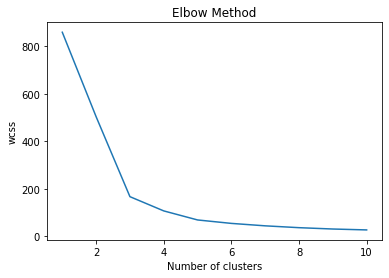

In [216]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

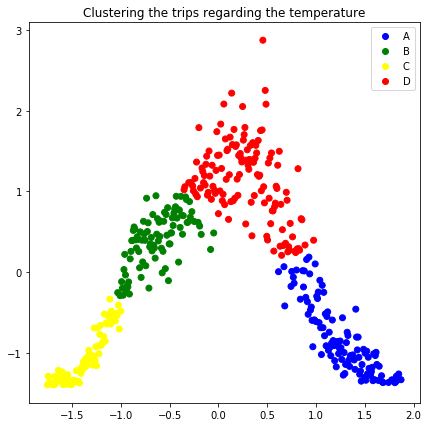

In [217]:
#plot the k-means
classes = ['A', 'B', 'C', 'D']
colours = ListedColormap(["blue", "green", "yellow", "red"])

means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.title("Clustering the trips regarding the temperature")

plt.show()

### Explanation 
You can see those trips that are going at a very low temperature, those at a high temperature and then going upwards with the amount of trips. So the most trips were made averagely between 10 to 20 degrees. However, it would make sense to put more clusters so low and high temperature dont get put together (that is what happened with HC that has been removed by now).
So the K-Means actually has a way better distribution with the 5 clusters.

- Cluster 1: low temperature, small size
- Cluster 2: low to med temp and med size
- Cluster 3: med temp and high size
- Cluster 4: high temp to med size and small size

# Clustering with Customers

## Customer to their amount of bookings and the mean duration

### Preparation

#### Preparation of the cluster tables

In [218]:
#count the amount of bookings per customers
#then count the average duration for these bookings
#combine the tables
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'duration', 'CUSTOMER_HAL_ID']]

In [219]:
cluster7 = cluster.groupby(by='CUSTOMER_HAL_ID', as_index=False)['BOOKING_HAL_ID'].count()
cluster7 = cluster7.drop('CUSTOMER_HAL_ID', axis=1)

In [220]:
cluster['duration'] = pd.to_numeric(cluster['duration'])
cluster8 = cluster.groupby(["CUSTOMER_HAL_ID"], as_index = False)['duration'].mean()
cluster8['duration'] = pd.to_timedelta(cluster8['duration'])
cluster8['duration']  = round(cluster8['duration'].dt.total_seconds()/60)
cluster8 = cluster8.drop('CUSTOMER_HAL_ID', axis=1)

In [221]:
cluster7 = pd.concat([cluster7, cluster8], axis=1)

In [222]:
#drop customers with too long bookings
indexNames = cluster7[ cluster7['duration'] > 10000 ].index
indexNames2 = cluster7[cluster7['duration'] < 60].index

In [223]:
cluster7 = cluster7.drop(indexNames)
cluster8 = cluster7.drop(indexNames2)

### K-Means

In [224]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster7)
X_scaled = scaler.transform(cluster7)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster7.columns, index=cluster7.index)
X_scaled_df.head()

,BOOKING_HAL_ID,duration
0,-0.315646,-0.020584
1,1.634351,-0.184906
2,-0.331630,-0.210851
3,-0.347613,-0.176257
4,-0.187778,-0.171933


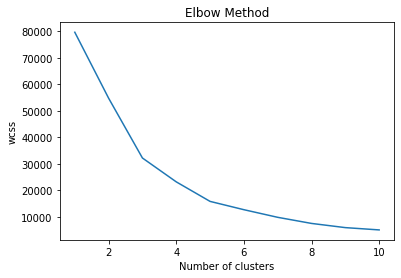

In [225]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

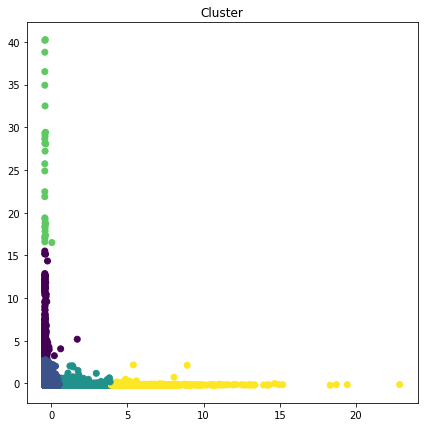

In [226]:
#plot the k-means
means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

In [227]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster8)
X_scaled = scaler.transform(cluster8)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster8.columns, index=cluster8.index)
X_scaled_df.head()

,BOOKING_HAL_ID,duration
14,-0.027614,-0.298859
16,-0.069142,-0.353959
18,-0.069142,0.658037
21,1.550440,-0.374162
24,-0.193725,-0.069278


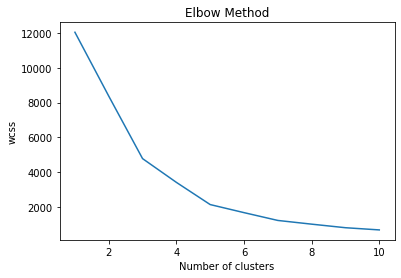

In [228]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

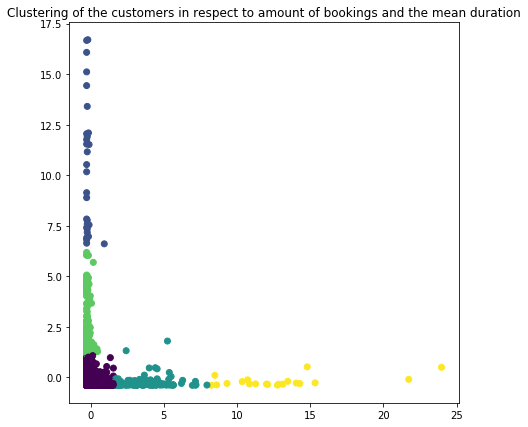

In [229]:
#plot the k-means
means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Clustering of the customers in respect to amount of bookings and the mean duration")

plt.show()

### Result:

Since this data set was way bigger than the other one before, it took a lot longer for the HC than the other ones before. So we decided to leave this out for now. K-Means  has shown the overall distribution by now. There are customers that have a very low amount of bookings with very low duration. Then there are those that have a low amount of bookings with a high duration. And then there are those that have a high amount of amount of bookings with very low duration. 

## Cluster Customers with Amount of Stations and Amount of Bookings

### Preparation

In [230]:
#get the amount of stations per customers
#get the amount of bookings per customers
#combine the tables
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]

In [231]:
cluster10 = cluster.groupby(['CUSTOMER_HAL_ID'], as_index = False).agg({'START_RENTAL_ZONE_HAL_ID': pd.Series.nunique})
cluster10 = cluster10.set_index('CUSTOMER_HAL_ID')

In [232]:
cluster11 = cluster.groupby(by='CUSTOMER_HAL_ID', as_index=False)['BOOKING_HAL_ID'].count()
cluster11 = cluster11.set_index('CUSTOMER_HAL_ID')

In [233]:
cluster12 = cluster10.merge(cluster11, left_index=True, right_index=True)

In [234]:
cluster12

,START_RENTAL_ZONE_HAL_ID,BOOKING_HAL_ID
CUSTOMER_HAL_ID,,
00001C3CCBB086C084B1E36B2B986404FFD80725,4.0,7
00021B1714F6E46647F51F765035016E71FF1C37,21.0,129
00022DE58A5753CE955509023F4C6C76C4BDAC1F,5.0,6
000A3C6364F62E83B51B7E2F2E8B361519BBE686,4.0,5
000B0C1AAE2E291E15CB838A4DDCCA89D4FA6E56,2.0,15
...,...,...
FFFC3BC1CF758885870179EAF568DAE3E0717F73,2.0,2
FFFC615ED810DA62250B5F615EE82C5ED866A0E0,27.0,75
FFFD0078967CBAF12C266EC4DD04F7F672F1A86F,1.0,1


In [235]:
indexNames = cluster12[ cluster12['BOOKING_HAL_ID'] > 11000 ].index
indexNames
cluster12 = cluster12.drop(indexNames)
indexNames = cluster12[ cluster12['START_RENTAL_ZONE_HAL_ID'] > 90 ].index
indexNames
cluster12 = cluster12.drop(indexNames)

### K-Means

In [236]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster12)
X_scaled = scaler.transform(cluster12)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster12.columns, index=cluster12.index)
X_scaled_df.head()

,START_RENTAL_ZONE_HAL_ID,BOOKING_HAL_ID
CUSTOMER_HAL_ID,,
00001C3CCBB086C084B1E36B2B986404FFD80725,-0.352455,-0.315862
00021B1714F6E46647F51F765035016E71FF1C37,1.626959,1.637764
00022DE58A5753CE955509023F4C6C76C4BDAC1F,-0.236019,-0.331875
000A3C6364F62E83B51B7E2F2E8B361519BBE686,-0.352455,-0.347888
000B0C1AAE2E291E15CB838A4DDCCA89D4FA6E56,-0.585327,-0.187755


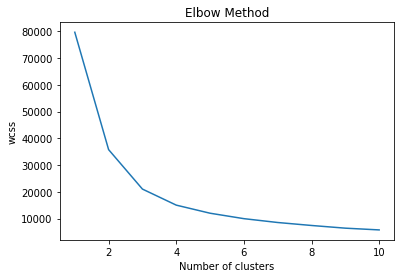

In [237]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

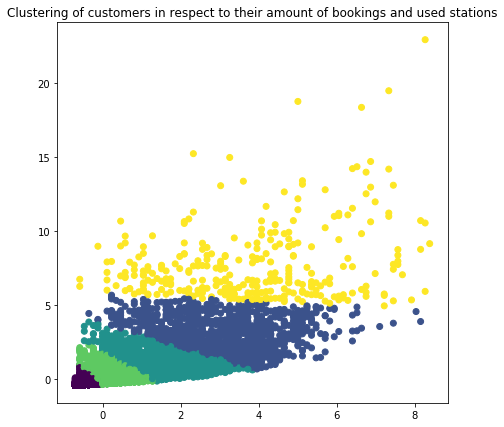

In [238]:
#plot the k-means
means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Clustering of customers in respect to their amount of bookings and used stations")

plt.show()

### Gaussian Mixture

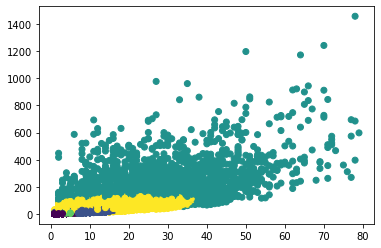

In [239]:
gmm = GaussianMixture(n_components=5).fit(cluster12)
labels = gmm.predict(cluster12)
plt.scatter(cluster12['START_RENTAL_ZONE_HAL_ID'], cluster12['BOOKING_HAL_ID'], c=labels, cmap='viridis')

### Result

This clustering does not really show relevant information. It's basically portraying that there are customers with little amount of bookings at few various stations and then it gets more and more, with the high variance in the outer area is clustered as one cluster, which means that customers with a lot of bookings at a few stations and the other way customers with a lot of different stations but rather few bookings are put into the same cluster which makes no real sense.

# Routes

## Routes to Amount of bookings and customers and duration

### Preparation

In [240]:
#get the routes
#get the amount of bookings per route
#get the amount of unique customers per route
#get the average duration per route
# 
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'END_RENTAL_ZONE', 'START_RENTAL_ZONE', 'CUSTOMER_HAL_ID', 'duration']]

In [241]:
a = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False)['BOOKING_HAL_ID'].count()

In [242]:
b = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})

In [243]:
cluster['duration'] = pd.to_numeric(cluster['duration'])
c = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False)['duration'].mean()
c['duration'] = pd.to_timedelta(c['duration'])
c['duration']  = round(c['duration'].dt.total_seconds()/60)

In [244]:
a = a.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)
b = b.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)
c = c.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)

In [245]:
cluster8 = pd.concat([a, b, c], axis=1)
cluster8

,BOOKING_HAL_ID,CUSTOMER_HAL_ID,duration
0,99,26,57.0
1,1,1,13.0
2,4,3,17.0
3,2,2,13.0
4,4,3,9.0
...,...,...,...
47099,3,3,15.0
47100,1,1,18.0
47101,5,2,18.0
47102,7,3,10.0


In [246]:
indexNames = cluster8[ cluster8['BOOKING_HAL_ID'] > 5000 ].index

In [247]:
indexNames

Int64Index([22416, 33188], dtype='int64')

In [248]:
cluster8 = cluster8.drop(indexNames)

In [249]:
indexNames = cluster8[ cluster8['CUSTOMER_HAL_ID'] > 2000 ].index

In [250]:
indexNames

Int64Index([22631], dtype='int64')

In [251]:
cluster8 = cluster8.drop(indexNames)

### sns-plot

If you rerun the code, remember to cluster the first kmeans and then run the first 3D model. Then go to second with more clsuters and run the next 3D model and so on. In total there are 3. Do that since the variable names haven't been changed yet.

In [252]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster8)
X_scaled = scaler.transform(cluster8)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster8.columns, index=cluster8.index)
X_scaled_df.head()

,BOOKING_HAL_ID,CUSTOMER_HAL_ID,duration
0,0.946707,0.580173,0.108645
1,-0.262646,-0.360587,-0.093463
2,-0.225625,-0.285326,-0.075090
3,-0.250306,-0.322956,-0.093463
4,-0.225625,-0.285326,-0.111837


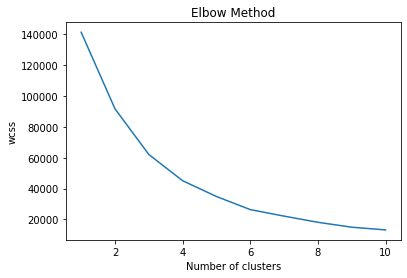

In [253]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [254]:
means = KMeans(n_clusters=4)
means.fit(X_scaled)
means.predict(X_scaled)
x_pred = means.predict(X_scaled)

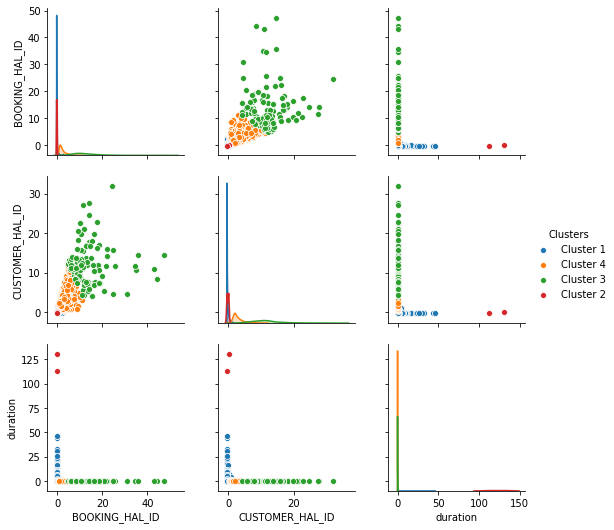

In [255]:
numbers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Clusters"]
X_scaled_df["Clusters"] = means.predict(X_scaled)
X_scaled_df["Clusters"] = X_scaled_df["Clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=X_scaled_df, hue="Clusters")

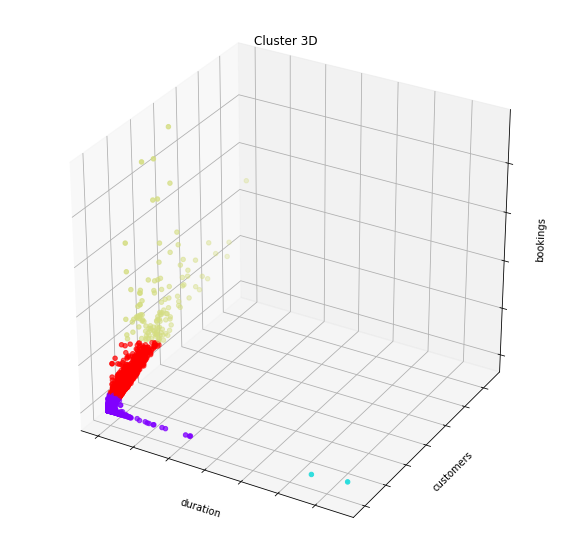

In [256]:
#plot with 4 clusters
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)

fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.plot3D(xline, yline, zline, 'gray')

ax = plt.axes(projection='3d')

ax.scatter3D(X_scaled[:, 2], X_scaled[:, 1], X_scaled[:, 0], c=x_pred, cmap='rainbow')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('customers')
ax.set_zlabel('bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

### Result

Actually quite close to the result as before. The duration has the effect of almost linear lines, most customers and bookings have a smal duration. Then there come less and less towards both axes. 
So we do not really get new information regarding certain routes. It's more or less the same distribution as we have seen for just the stations. Also the duration shows the same value before, more bookings for less time and less booking for longer routes. Which also makes sense since less time equals less payment.


# Prediction

In [257]:
#read data into a dataframe; file was created above

df_fulldata = pd.read_csv("DataBase_WeatherRentalAmount_UTC.csv", index_col='FormattedDate')

## Linear Regression with multiple input features

In [258]:
#classic cross-validation test
x_train, x_test, y_train, y_test = train_test_split(df_fulldata[['Temperature','PrecipitationHeight','TotalCloudCover','MeanWindSpeed','Month','Weekday','Hour']], df_fulldata[['Rentals']], test_size=0.3)

In [259]:
def LinRegPipeline(x_train, y_train, x_test, y_test):
    """Training and Testing a Linear Regression model based on training and test set of x and y; Returning rsme and r2 of test set"""
    reg = linear_model.LinearRegression()
    reg.fit(x_train,y_train)
    y_pred_train = reg.predict(x_train)
    y_pred = reg.predict(x_test)
    
    
    #ns rounding prediction values
    np.ceil(y_pred,out=y_pred)
    np.ceil(y_pred_train, out=y_pred_train)
    
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2_test = metrics.r2_score(y_test, y_pred)
    
    print("Training performance \n")
    print("RMSE: " + str(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))))
    print("R^2: " + str(metrics.r2_score(y_train, y_pred_train)))
    print("\n Test performance \n")
    print("RMSE: " + str(rmse_test))
    print("R^2: " + str(r2_test))
    return rmse_test, r2_test

In [260]:
LinRegPipeline(x_train, y_train, x_test, y_test)

Training performance 

RMSE: 57.90651794786927
R^2: 0.2529952718461381

 Test performance 

RMSE: 57.28102549238244
R^2: 0.25710709075708915


(57.28102549238244, 0.25710709075708915)

In [261]:
#Linear Regression model with all parameters shows bad performance
#This is due to the fact, that not all parameters are actually linear.
#For comparison: Training one model with only linear parameters (temperature & precipitation).

#classic cross-validation testset
x_train_lin, x_test_lin, y_train_lin, y_test_lin = train_test_split(df_fulldata[['Temperature','PrecipitationHeight']], df_fulldata[['Rentals']], test_size=0.3)

LinRegPipeline (x_train_lin, y_train_lin, x_test_lin, y_test_lin)


Training performance 

RMSE: 58.0194480479738
R^2: 0.24663495490064424

 Test performance 

RMSE: 59.16618897591031
R^2: 0.21586333647377187


(59.16618897591031, 0.21586333647377187)

In [262]:
#Performance has not improved. Therefore linear models can be discarded. Also indication that these weather features are not sufficient to predict the bike rental behaviour.

## Polynomial Approach
### Model functions

In [263]:
def polynomialregression(deg, xtr, xte, ytr, yte):
    """Polynomial regression. Input: Regression degree, xtrain, xtest, ytrain, ytest. Returns r2_train, r2_test"""
    xtrain_array = np.array(xtr)
    xtest_array = np.array(xte)
    ytrain_array = np.array(ytr)
    ytest_array = np.array(yte)
    
    poly = PolynomialFeatures(degree = deg, include_bias=False)
    poly_xtrain = poly.fit_transform(xtrain_array)
    
    
    poly_model = linear_model.LinearRegression()
    poly_model.fit(poly_xtrain, ytrain_array)
    
    y_train_predicted = poly_model.predict(poly_xtrain)
    np.ceil(y_train_predicted,out=y_train_predicted)
    
    poly1 = PolynomialFeatures(degree = deg, include_bias=False)
    poly_xtest = poly1.fit_transform(xtest_array)
    y_test_predicted = poly_model.predict(poly_xtest)
    np.ceil(y_test_predicted,out=y_test_predicted)
    
    #evaluating train
    rmse_train = np.sqrt(metrics.mean_squared_error(ytrain_array, y_train_predicted))
    r2_train = metrics.r2_score(ytrain_array, y_train_predicted)
    
    # evaluating test
    rmse_test = np.sqrt(metrics.mean_squared_error(ytest_array, y_test_predicted))
    r2_test = metrics.r2_score(ytest_array, y_test_predicted)
    
    print("Testing the polynomial function of degree {}".format(deg))
    
    print("\n")
    
    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    
    print("\n")
    
    print("The model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))
    
    print("\n")
    print("\n")
    
    return rmse_train, rmse_test, r2_train, r2_test, poly_model

In [264]:
def polynomialregression_lasso(deg, reg_par, x_train_inp, x_test_inp, y_train_inp, y_test_inp):
    """Polynomial Regrisson with LASSO ragularization. Input: degree, regularization parameter, x_train, x_test, y_train, y_test. Returns rsme_test, r2_test and the model"""
    
    xtrain_array = np.array(x_train_inp)
    xtest_array = np.array(x_test_inp)
    ytrain_array = np.array(y_train_inp)
    ytest_array = np.array(y_test_inp)
    
    poly = PolynomialFeatures(degree = deg, include_bias=False)
    poly_xtrain = poly.fit_transform(xtrain_array)
    
    #Training the model
    poly_model_L1 = linear_model.Lasso(alpha = reg_par, normalize=False)
    poly_model_L1.fit(poly_xtrain, ytrain_array)
    
    y_train_predicted = poly_model_L1.predict(poly_xtrain)
    np.ceil(y_train_predicted,out=y_train_predicted)
    
    poly1 = PolynomialFeatures(degree = deg, include_bias=False)
    poly_xtest = poly1.fit_transform(xtest_array)
    y_test_predicted = poly_model_L1.predict(poly_xtest)
    np.ceil(y_test_predicted,out=y_test_predicted)
    
    #evaluating train
    rmse_train = np.sqrt(metrics.mean_squared_error(ytrain_array, y_train_predicted))
    r2_train = metrics.r2_score(ytrain_array, y_train_predicted)
    
    # evaluating test
    rmse_test = np.sqrt(metrics.mean_squared_error(ytest_array, y_test_predicted))
    r2_test = metrics.r2_score(ytest_array, y_test_predicted)
    
    print("Testing the polynomial function with LASSO regularization of degree {}".format(deg))
    
    print("\n")
    
    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    
    print("\n")
    
    print("The model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))
    
    print("\n")
    print("\n")
    #print("Rounded y_train_predicted is   ", y_train_predicted)
    #print ("Rounded y_test_predicted is   ", y_test_predicted)
    
    return rmse_train, rmse_test, r2_train, r2_test, poly_model_L1

### Creating a training (50 %), cross validation (20 %) and test (30 %) set for polynomial regression

In [265]:
#train, validation, test split

X = np.array([df_fulldata["Temperature"].values, np.ones(len(df_fulldata))]).T
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.5)]
idx_cv = perm[int(len(perm)*0.5):]

idx_test = idx_cv[:int(len(idx_cv)*0.6)]
idx_validation = idx_cv[int(len(idx_cv)*0.6):]

x_train, y_train = df_fulldata[['Temperature','PrecipitationHeight','TotalCloudCover','MeanWindSpeed','Month','Weekday','Hour']].iloc[idx_train].values, df_fulldata["Rentals"].iloc[idx_train].values
x_validation, y_validation = df_fulldata[['Temperature','PrecipitationHeight','TotalCloudCover','MeanWindSpeed','Month','Weekday','Hour']].iloc[idx_validation].values, df_fulldata["Rentals"].iloc[idx_validation].values
x_test, y_test = df_fulldata[['Temperature','PrecipitationHeight','TotalCloudCover','MeanWindSpeed','Month','Weekday','Hour']].iloc[idx_test].values, df_fulldata["Rentals"].iloc[idx_test].values


## Polynomial Regression

In [266]:
degr = [1,2,3,4,5]
rmse_train_lst = []
rmse_test_lst = []
r2_train_lst = []
r2_val_lst = []
model_lst = []

for d in degr:
    rmsetrain, rmsetest, r2train, r2test, model = polynomialregression(d, x_train, x_validation, y_train, y_validation)
    rmse_train_lst.append(rmsetrain)
    rmse_test_lst.append(rmsetest)
    r2_train_lst.append(r2train)
    r2_val_lst.append(r2test)
    model_lst.append(model)
    
    

Testing the polynomial function of degree 1


The model performance for the training set
-------------------------------------------
RMSE of training set is 56.31422310274919
R2 score of training set is 0.25666364329886127


The model performance for the test set
-------------------------------------------
RMSE of test set is 58.05137218431782
R2 score of test set is 0.2572630622061475




Testing the polynomial function of degree 2


The model performance for the training set
-------------------------------------------
RMSE of training set is 46.99393340168268
R2 score of training set is 0.48235410451550953


The model performance for the test set
-------------------------------------------
RMSE of test set is 48.74459875376965
R2 score of test set is 0.4763235513199423




Testing the polynomial function of degree 3


The model performance for the training set
-------------------------------------------
RMSE of training set is 44.85460882130776
R2 score of training set is 0.528411367

In [267]:
mpd = rmse_test_lst.index(min(rmse_test_lst))+1 #most performant degree

print("Best performance for model of degree " + str(mpd) + " with performance of R2-Score " + str(r2_val_lst[(mpd-1)]))

Best performance for model of degree 3 with performance of R2-Score 0.5090117257916322


In [268]:
#Performance of polynomial model
df_ppm = pd.DataFrame(list(zip(degr, rmse_train_lst, rmse_test_lst)), 
               columns =['Degree', 'Training Error', 'Validation Error'])

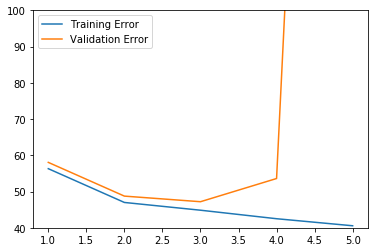

In [269]:
plt.plot(df_ppm['Degree'],df_ppm['Training Error'], label = 'Training Error')
plt.plot(df_ppm['Degree'],df_ppm['Validation Error'], label = 'Validation Error')
plt.ylim(40, 100)
plt.legend()

In [270]:
rmsetrain, rmsetest, r2train, r2test, model = polynomialregression(mpd, x_train, x_test, y_train, y_test)

Testing the polynomial function of degree 3


The model performance for the training set
-------------------------------------------
RMSE of training set is 44.85460882130776
R2 score of training set is 0.5284113678885913


The model performance for the test set
-------------------------------------------
RMSE of test set is 49.333064799771726
R2 score of test set is 0.4878192285265771






### LASSO regularization

In [271]:
degr = [1,2,3,4,5,6,7,8,9]
rmse_train_lst = []
rmse_val_lst = []
model_lst = []
r2_train_lst = []
r2_val_lst = []

for d in degr:
    rmsetrain, rmseval, r2train, r2test, mod = polynomialregression_lasso(d, 0.1, x_train, x_validation, y_train, y_validation)
    rmse_train_lst.append(rmsetrain)
    rmse_val_lst.append(rmseval)
    r2_train_lst.append(r2train)
    r2_val_lst.append(r2test)
    model_lst.append(mod)

Testing the polynomial function with LASSO regularization of degree 1


The model performance for the training set
-------------------------------------------
RMSE of training set is 56.31856919125444
R2 score of training set is 0.2565489038927403


The model performance for the test set
-------------------------------------------
RMSE of test set is 58.060612877751275
R2 score of test set is 0.25702658370965625




Testing the polynomial function with LASSO regularization of degree 2


The model performance for the training set
-------------------------------------------
RMSE of training set is 47.04150159993851
R2 score of training set is 0.4813056311067122


The model performance for the test set
-------------------------------------------
RMSE of test set is 48.708954704987775
R2 score of test set is 0.47708913867551506




Testing the polynomial function with LASSO regularization of degree 3


The model performance for the training set
-------------------------------------------
R

Best performance for model of degree 9 with performance of R2-Score 0.5562728169486877


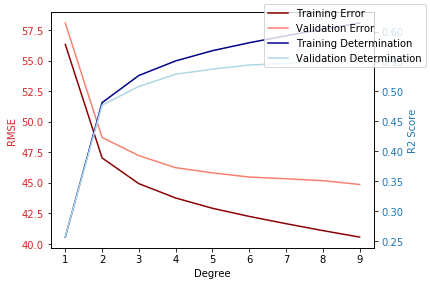

53.91489208110142 0.38826327031258456


In [272]:
mpd = r2_val_lst.index(max(r2_val_lst))+1 #most performant degree
best_model = model_lst[(mpd-1)]

print("Best performance for model of degree " + str(mpd) + " with performance of R2-Score " + str(r2_val_lst[(mpd-1)]))

#Performance of polynomial model
df_ppm = pd.DataFrame(list(zip(degr, rmse_train_lst, rmse_val_lst, r2_train_lst, r2_val_lst)), 
               columns =['Degree', 'Training Error', 'Validation Error', 'Training Determination', 'Validation Determination'])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Degree')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(df_ppm['Degree'],df_ppm['Training Error'], color='darkred', label= 'Training Error')
ax1.plot(df_ppm['Degree'],df_ppm['Validation Error'], color='salmon',label = 'Validation Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(df_ppm['Degree'], df_ppm['Training Determination'], color='darkblue', label = 'Training Determination')
ax2.plot(df_ppm['Degree'], df_ppm['Validation Determination'], color='lightblue', label = 'Validation Determination')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend()
plt.show()

# evaluating on test
x_test_array = np.array(x_test)
poly = PolynomialFeatures(degree = mpd, include_bias=False)
poly_xtest = poly.fit_transform(x_test_array)

best_prediction = best_model.predict(poly_xtest)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, best_prediction))
r2_test = metrics.r2_score(y_test, best_prediction)

print(rmse_test, r2_test)
#rmsetrain, rmsetest = polynomialregression(mpd, x_train, x_test, y_train, y_test)

## Slimmed feature set

In [273]:
# slimming down the data set to only the relevant features
df_slim = df_fulldata[['Temperature','Month','Weekday','Hour','Year','Rentals']]

In [274]:
cv_option1 = True # two different ways of train, validation, test splitting to be determined by variable
normalize_data = False # Normalizing the initial dataframe for later regression

if normalize_data:
    normalized_df = df_slim
    normalized_df['Temperature'] = np.divide(np.subtract(normalized_df['Temperature'],normalized_df['Temperature'].mean()),normalized_df['Temperature'].std())
    normalized_df['Month'] = np.divide(np.subtract(normalized_df['Month'],normalized_df['Month'].mean()),normalized_df['Month'].std())
    normalized_df['Weekday'] = np.divide(np.subtract(normalized_df['Weekday'],normalized_df['Weekday'].mean()),normalized_df['Weekday'].std())
    normalized_df['Hour'] = np.divide(np.subtract(normalized_df['Hour'],normalized_df['Hour'].mean()),normalized_df['Hour'].std())
    normalized_df['Year'] = np.divide(np.subtract(normalized_df['Year'],normalized_df['Year'].mean()),normalized_df['Year'].std())

    df_slim = normalized_df

if cv_option1 :
    X = np.array([df_slim['Temperature'].values, np.ones(len(df_slim))]).T
    np.random.seed(10)
    perm = np.random.permutation(X.shape[0])
    idx_train = perm[:int(len(perm)*0.5)]
    idx_cv = perm[int(len(perm)*0.5):]

    idx_test = idx_cv[:int(len(idx_cv)*0.6)]
    idx_validation = idx_cv[int(len(idx_cv)*0.6):]

    x_train, y_train = df_slim[['Temperature','Month','Weekday','Hour','Year']].iloc[idx_train].values, df_slim["Rentals"].iloc[idx_train].values
    x_validation, y_validation = df_slim[['Temperature','Month','Weekday','Hour','Year']].iloc[idx_validation].values, df_slim["Rentals"].iloc[idx_validation].values
    x_test, y_test = df_slim[['Temperature','Month','Weekday','Hour','Year']].iloc[idx_test].values, df_slim["Rentals"].iloc[idx_test].values
    
else:
    x_train, x_holdout, y_train, y_holdout = train_test_split(df_slim[['Temperature','Month','Weekday','Hour','Year']], df_slim[['Rentals']], test_size=0.3)
    x_validation, x_test, y_validation, y_test = train_test_split(x_holdout, y_holdout, test_size=0.6)



In [275]:
degr = np.arange(1,19,1) #analyzing degree 1 til 18
rmse_train_lst = []
rmse_val_lst = []
model_lst = []
r2_train_lst = []
r2_val_lst = []
# lists to store the results of the different models for later comparison

for d in degr:
    rmsetrain, rmseval, r2train, r2test, mod = polynomialregression_lasso(d, 0.1, x_train, x_validation, y_train, y_validation)
    rmse_train_lst.append(rmsetrain)
    rmse_val_lst.append(rmseval)
    r2_train_lst.append(r2train)
    r2_val_lst.append(r2test)
    model_lst.append(mod)

Testing the polynomial function with LASSO regularization of degree 1


The model performance for the training set
-------------------------------------------
RMSE of training set is 53.573505551121286
R2 score of training set is 0.32725680906655885


The model performance for the test set
-------------------------------------------
RMSE of test set is 55.3810371530459
R2 score of test set is 0.3240225434128031




Testing the polynomial function with LASSO regularization of degree 2


The model performance for the training set
-------------------------------------------
RMSE of training set is 44.71626743863368
R2 score of training set is 0.5313158460504763


The model performance for the test set
-------------------------------------------
RMSE of test set is 46.040096764850986
R2 score of test set is 0.5328218756890755




Testing the polynomial function with LASSO regularization of degree 3


The model performance for the training set
-------------------------------------------
RMS

Best performance for model of degree 18 with performance of R2-Score 0.6443265429650169


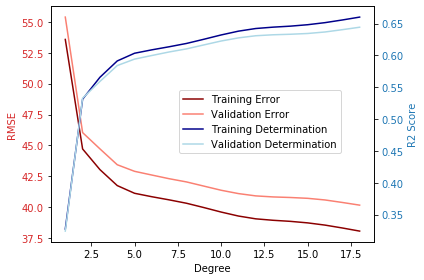

42.66229462306234 0.6169676122961185


In [276]:
mpd = r2_val_lst.index(max(r2_val_lst))+1 #most performant degree
best_model = model_lst[(mpd-1)]

print("Best performance for model of degree " + str(mpd) + " with performance of R2-Score " + str(r2_val_lst[(mpd-1)]))

#Performance of polynomial model
df_ppm = pd.DataFrame(list(zip(degr, rmse_train_lst, rmse_val_lst, r2_train_lst, r2_val_lst)), 
               columns =['Degree', 'Training Error', 'Validation Error', 'Training Determination', 'Validation Determination'])
#having a df for the most performing model

fig, ax1 = plt.subplots()

#creating a two sided plot for determination and error
color = 'tab:red'
ax1.set_xlabel('Degree')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(df_ppm['Degree'],df_ppm['Training Error'], color='darkred', label= 'Training Error')
ax1.plot(df_ppm['Degree'],df_ppm['Validation Error'], color='salmon',label = 'Validation Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(df_ppm['Degree'], df_ppm['Training Determination'], color='darkblue', label = 'Training Determination')
ax2.plot(df_ppm['Degree'], df_ppm['Validation Determination'], color='lightblue', label = 'Validation Determination')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='center right', bbox_to_anchor=(0,0,0.8,1.1)) #position legend so that graph & axes is visible
plt.show()

# evaluating on test
x_test_array = np.array(x_test)
poly = PolynomialFeatures(degree = mpd, include_bias=False)
poly_xtest = poly.fit_transform(x_test_array)

best_prediction = best_model.predict(poly_xtest)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, best_prediction))
r2_test = metrics.r2_score(y_test, best_prediction)

print(rmse_test, r2_test)
#rmsetrain, rmsetest = polynomialregression(mpd, x_train, x_test, y_train, y_test)

## Normalizing the input features

In [277]:
df_slim = df_fulldata[['Temperature','Month','Weekday','Hour','Year','Rentals']]
cv_option1 = True # two different ways of train, validation, test splitting to be determined by variable
normalize_data = True # normalizing the data

if normalize_data:
    normalized_df = df_slim
    normalized_df['Temperature'] = np.divide(np.subtract(normalized_df['Temperature'],normalized_df['Temperature'].mean()),normalized_df['Temperature'].std())
    normalized_df['Month'] = np.divide(np.subtract(normalized_df['Month'],normalized_df['Month'].mean()),normalized_df['Month'].std())
    normalized_df['Weekday'] = np.divide(np.subtract(normalized_df['Weekday'],normalized_df['Weekday'].mean()),normalized_df['Weekday'].std())
    normalized_df['Hour'] = np.divide(np.subtract(normalized_df['Hour'],normalized_df['Hour'].mean()),normalized_df['Hour'].std())
    normalized_df['Year'] = np.divide(np.subtract(normalized_df['Year'],normalized_df['Year'].mean()),normalized_df['Year'].std())
    
    df_slim = normalized_df

if cv_option1 :
    X = np.array([df_slim['Temperature'].values, np.ones(len(df_slim))]).T
    np.random.seed(10)
    perm = np.random.permutation(X.shape[0])
    idx_train = perm[:int(len(perm)*0.5)]
    idx_cv = perm[int(len(perm)*0.5):]

    idx_test = idx_cv[:int(len(idx_cv)*0.6)]
    idx_validation = idx_cv[int(len(idx_cv)*0.6):]

    x_train, y_train = df_slim[['Temperature','Month','Weekday','Hour','Year']].iloc[idx_train].values, df_slim["Rentals"].iloc[idx_train].values
    x_validation, y_validation = df_slim[['Temperature','Month','Weekday','Hour','Year']].iloc[idx_validation].values, df_slim["Rentals"].iloc[idx_validation].values
    x_test, y_test = df_slim[['Temperature','Month','Weekday','Hour','Year']].iloc[idx_test].values, df_slim["Rentals"].iloc[idx_test].values
    
else:
    x_train, x_holdout, y_train, y_holdout = train_test_split(df_slim[['Temperature','Month','Weekday','Hour','Year']], df_slim[['Rentals']], test_size=0.3)
    x_validation, x_test, y_validation, y_test = train_test_split(x_holdout, y_holdout, test_size=0.6)



In [278]:
degr = np.arange(1,16,1) #analyzing degree 1 til 15
#storing all the results in lists for later analysis
rmse_train_lst = []
rmse_val_lst = []
model_lst = []
r2_train_lst = []
r2_val_lst = []

for d in degr:
    rmsetrain, rmseval, r2train, r2test, mod = polynomialregression_lasso(d, 0.1, x_train, x_validation, y_train, y_validation)
    rmse_train_lst.append(rmsetrain)
    rmse_val_lst.append(rmseval)
    r2_train_lst.append(r2train)
    r2_val_lst.append(r2test)
    model_lst.append(mod)

Testing the polynomial function with LASSO regularization of degree 1


The model performance for the training set
-------------------------------------------
RMSE of training set is 53.56995609554325
R2 score of training set is 0.3273459498813748


The model performance for the test set
-------------------------------------------
RMSE of test set is 55.380167500722614
R2 score of test set is 0.3240437730892477




Testing the polynomial function with LASSO regularization of degree 2


The model performance for the training set
-------------------------------------------
RMSE of training set is 42.94736648724453
R2 score of training set is 0.5676631468960134


The model performance for the test set
-------------------------------------------
RMSE of test set is 44.09798605260445
R2 score of test set is 0.5714045514782183




Testing the polynomial function with LASSO regularization of degree 3


The model performance for the training set
-------------------------------------------
RMSE

Best performance for model of degree 12 with performance of R2-Score 0.7481010956273686


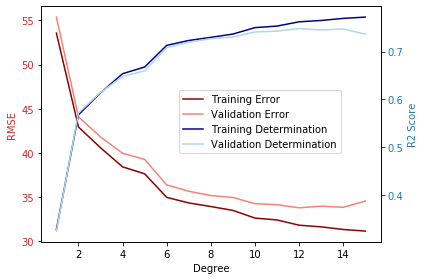

36.06166897539057 0.7263227346902432


In [279]:
mpd = r2_val_lst.index(max(r2_val_lst))+1 #most performant degree
best_model = model_lst[(mpd-1)]

print("Best performance for model of degree " + str(mpd) + " with performance of R2-Score " + str(r2_val_lst[(mpd-1)]))

#Performance of polynomial model
df_ppm = pd.DataFrame(list(zip(degr, rmse_train_lst, rmse_val_lst, r2_train_lst, r2_val_lst)), 
               columns =['Degree', 'Training Error', 'Validation Error', 'Training Determination', 'Validation Determination'])

#plotting the performance on train and validation
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Degree')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(df_ppm['Degree'],df_ppm['Training Error'], color='darkred', label= 'Training Error')
ax1.plot(df_ppm['Degree'],df_ppm['Validation Error'], color='salmon',label = 'Validation Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(df_ppm['Degree'], df_ppm['Training Determination'], color='darkblue', label = 'Training Determination')
ax2.plot(df_ppm['Degree'], df_ppm['Validation Determination'], color='lightblue', label = 'Validation Determination')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='center right', bbox_to_anchor=(0,0,0.8,1.1)) #position legend so that graph & axes is visible
plt.show()

# evaluating on test
x_test_array = np.array(x_test)
poly = PolynomialFeatures(degree = mpd, include_bias=False)
poly_xtest = poly.fit_transform(x_test_array)

best_prediction = best_model.predict(poly_xtest)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, best_prediction))
r2_test = metrics.r2_score(y_test, best_prediction)

print(rmse_test, r2_test)
#rmsetrain, rmsetest = polynomialregression(mpd, x_train, x_test, y_train, y_test)

## Prediction model for time frame aggregation

### 2h

In [280]:
df2 = pd.read_csv("DataBase_WeatherRentalAmount_2h_UTC.csv", index_col='grp')
df2.describe()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Year,Rentals
count,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000
mean,11.376482,5.371295,0.123347,3.404195,6.519836,3.008037,2015.500570,139.292294
std,7.839789,2.546550,0.733339,2.085740,3.448657,1.969271,0.500085,128.885018
min,-7.050000,-1.000000,0.000000,0.000000,1.000000,0.000000,2014.500000,0.000000
25%,5.100000,3.500000,0.000000,1.850000,4.000000,1.000000,2015.000000,40.000000
50%,10.800000,6.500000,0.000000,2.900000,7.000000,3.000000,2016.000000,103.000000
75%,16.950000,7.000000,0.000000,4.500000,10.000000,5.000000,2016.000000,203.000000
max,37.950000,8.000000,32.500000,17.450000,12.000000,6.000000,2016.000000,792.000000


In [281]:
#Normalizing

normalized_df = df2
normalized_df['Temperature'] = np.divide(np.subtract(normalized_df['Temperature'],normalized_df['Temperature'].mean()),normalized_df['Temperature'].std())
normalized_df['Month'] = np.divide(np.subtract(normalized_df['Month'],normalized_df['Month'].mean()),normalized_df['Month'].std())
normalized_df['Weekday'] = np.divide(np.subtract(normalized_df['Weekday'],normalized_df['Weekday'].mean()),normalized_df['Weekday'].std())
normalized_df['Year'] = np.divide(np.subtract(normalized_df['Year'],normalized_df['Year'].mean()),normalized_df['Year'].std())
df2 = normalized_df

#classic cross-validation test
x_train2, x_test2, y_train2, y_test2 = train_test_split(df2[['Temperature','Month','Weekday','Year']], df2[['Rentals']], test_size=0.5)
x_validation2, x_test2, y_validation2, y_test2 = train_test_split(x_test2,y_test2,test_size=0.6)

In [282]:
degr = np.arange(1,15)
rmse_train_lst = []
rmse_val_lst = []
model_lst = []
r2_train_lst = []
r2_val_lst = []
# lists to store the results of the different models

for d in degr:
    rmsetrain, rmseval, r2train, r2test, mod = polynomialregression_lasso(d, 0.1, x_train2, x_validation2, y_train2, y_validation2)
    rmse_train_lst.append(rmsetrain)
    rmse_val_lst.append(rmseval)
    r2_train_lst.append(r2train)
    r2_val_lst.append(r2test)
    model_lst.append(mod)
    

Testing the polynomial function with LASSO regularization of degree 1


The model performance for the training set
-------------------------------------------
RMSE of training set is 107.63436549144944
R2 score of training set is 0.32696760804423486


The model performance for the test set
-------------------------------------------
RMSE of test set is 104.72033941354046
R2 score of test set is 0.33754811958486264




Testing the polynomial function with LASSO regularization of degree 2


The model performance for the training set
-------------------------------------------
RMSE of training set is 99.47122395851392
R2 score of training set is 0.42518382518885356


The model performance for the test set
-------------------------------------------
RMSE of test set is 97.40263975032029
R2 score of test set is 0.4268956445887777




Testing the polynomial function with LASSO regularization of degree 3


The model performance for the training set
-------------------------------------------


Best performance for model of degree 8 with performance of R2-Score 0.46091946870585776


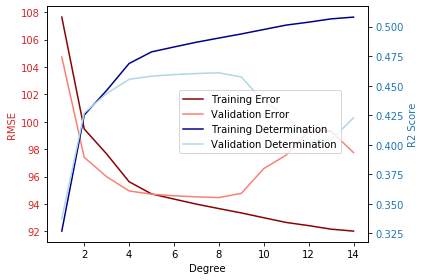

92.99386623728806 0.44678034942281364


In [283]:
mpd = r2_val_lst.index(max(r2_val_lst))+1 #most performant degree
best_model = model_lst[(mpd-1)]

print("Best performance for model of degree " + str(mpd) + " with performance of R2-Score " + str(r2_val_lst[(mpd-1)]))

#Performance of polynomial model
df_ppm = pd.DataFrame(list(zip(degr, rmse_train_lst, rmse_val_lst, r2_train_lst, r2_val_lst)), 
               columns =['Degree', 'Training Error', 'Validation Error', 'Training Determination', 'Validation Determination'])


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Degree')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(df_ppm['Degree'],df_ppm['Training Error'], color='darkred', label= 'Training Error')
ax1.plot(df_ppm['Degree'],df_ppm['Validation Error'], color='salmon',label = 'Validation Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(df_ppm['Degree'], df_ppm['Training Determination'], color='darkblue', label = 'Training Determination')
ax2.plot(df_ppm['Degree'], df_ppm['Validation Determination'], color='lightblue', label = 'Validation Determination')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='center right', bbox_to_anchor=(0,0,0.8,1.1)) #position legend so that graph & axes is visible
plt.show()

# evaluating on test
x_test_array = np.array(x_test2)
poly = PolynomialFeatures(degree = mpd, include_bias=False)
poly_xtest = poly.fit_transform(x_test_array)

best_prediction = best_model.predict(poly_xtest)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test2, best_prediction))
r2_test = metrics.r2_score(y_test2, best_prediction)

print(rmse_test, r2_test)
#rmsetrain, rmsetest = polynomialregression(mpd, x_train, x_test, y_train, y_test)

### 6h

In [284]:
df6 = pd.read_csv("DataBase_WeatherRentalAmount_6h_UTC.csv", index_col='grp')
df6.describe()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Year,Rentals
count,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000
mean,11.357182,5.433824,0.370041,3.377753,6.519836,3.008208,2015.500684,417.876881
std,7.770465,2.509813,1.490533,2.003239,3.450141,2.001009,0.500085,343.441629
min,-6.500000,-1.000000,0.000000,0.000000,1.000000,0.000000,2015.000000,0.000000
25%,5.087500,3.500000,0.000000,1.900000,4.000000,1.000000,2015.000000,132.750000
50%,10.850000,6.500000,0.000000,2.850000,7.000000,3.000000,2016.000000,345.000000
75%,16.900000,7.000000,0.000000,4.412500,10.000000,5.000000,2016.000000,599.000000
max,37.200000,8.000000,38.100000,16.100000,12.000000,6.000000,2016.000000,1706.000000


In [285]:
#Normalizing

normalized_df = df6
normalized_df['Temperature'] = np.divide(np.subtract(normalized_df['Temperature'],normalized_df['Temperature'].mean()),normalized_df['Temperature'].std())
normalized_df['Month'] = np.divide(np.subtract(normalized_df['Month'],normalized_df['Month'].mean()),normalized_df['Month'].std())
normalized_df['Weekday'] = np.divide(np.subtract(normalized_df['Weekday'],normalized_df['Weekday'].mean()),normalized_df['Weekday'].std())
normalized_df['Year'] = np.divide(np.subtract(normalized_df['Year'],normalized_df['Year'].mean()),normalized_df['Year'].std())
df6 = normalized_df

#classic cross-validation test
x_train6, x_test6, y_train6, y_test6 = train_test_split(df6[['Temperature','Month','Weekday','Year']], df6[['Rentals']], test_size=0.5)
x_validation6, x_test6, y_validation6, y_test6 = train_test_split(x_test6,y_test6,test_size=0.6)

In [286]:
degr = np.arange(1,15)
rmse_train_lst = []
rmse_val_lst = []
model_lst = []
r2_train_lst = []
r2_val_lst = []
# lists to store the results of the different models

for d in degr:
    rmsetrain, rmseval, r2train, r2test, mod = polynomialregression_lasso(d, 0.1, x_train6, x_validation6, y_train6, y_validation6)
    rmse_train_lst.append(rmsetrain)
    rmse_val_lst.append(rmseval)
    r2_train_lst.append(r2train)
    r2_val_lst.append(r2test)
    model_lst.append(mod)
    

Testing the polynomial function with LASSO regularization of degree 1


The model performance for the training set
-------------------------------------------
RMSE of training set is 263.2981280616444
R2 score of training set is 0.4093985833783723


The model performance for the test set
-------------------------------------------
RMSE of test set is 254.60342517253974
R2 score of test set is 0.43748486560555966




Testing the polynomial function with LASSO regularization of degree 2


The model performance for the training set
-------------------------------------------
RMSE of training set is 234.87065159831303
R2 score of training set is 0.5300448137397683


The model performance for the test set
-------------------------------------------
RMSE of test set is 229.98117850327105
R2 score of test set is 0.5410236393431729




Testing the polynomial function with LASSO regularization of degree 3


The model performance for the training set
-------------------------------------------
R

Best performance for model of degree 4 with performance of R2-Score 0.5706930082535306


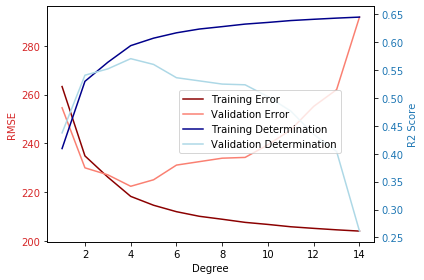

238.448559018932 0.5278606222212461


In [287]:
mpd = r2_val_lst.index(max(r2_val_lst))+1 #most performant degree
best_model = model_lst[(mpd-1)]

print("Best performance for model of degree " + str(mpd) + " with performance of R2-Score " + str(r2_val_lst[(mpd-1)]))

#Performance of polynomial model
df_ppm = pd.DataFrame(list(zip(degr, rmse_train_lst, rmse_val_lst, r2_train_lst, r2_val_lst)), 
               columns =['Degree', 'Training Error', 'Validation Error', 'Training Determination', 'Validation Determination'])


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Degree')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(df_ppm['Degree'],df_ppm['Training Error'], color='darkred', label= 'Training Error')
ax1.plot(df_ppm['Degree'],df_ppm['Validation Error'], color='salmon',label = 'Validation Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(df_ppm['Degree'], df_ppm['Training Determination'], color='darkblue', label = 'Training Determination')
ax2.plot(df_ppm['Degree'], df_ppm['Validation Determination'], color='lightblue', label = 'Validation Determination')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='center right', bbox_to_anchor=(0,0,0.8,1.1)) #position legend so that graph & axes is visible
plt.show()

# evaluating on test
x_test_array = np.array(x_test6)
poly = PolynomialFeatures(degree = mpd, include_bias=False)
poly_xtest = poly.fit_transform(x_test_array)

best_prediction = best_model.predict(poly_xtest)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test6, best_prediction))
r2_test = metrics.r2_score(y_test6, best_prediction)

print(rmse_test, r2_test)

### 24h

In [288]:
df24 = pd.read_csv("DataBase_WeatherRentalAmount_24h_UTC.csv", index_col='grp')
df24.describe()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Year,Rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,11.345280,5.676471,1.480164,3.365937,6.519836,3.008208,2015.500684,1671.507524
std,7.209059,2.266110,3.556072,1.710134,3.451913,2.002037,0.500342,915.966595
min,-5.800000,0.000000,0.000000,1.000000,1.000000,0.000000,2015.000000,0.000000
25%,5.275000,4.500000,0.000000,2.100000,4.000000,1.000000,2015.000000,958.000000
50%,10.850000,7.000000,0.000000,2.950000,7.000000,3.000000,2016.000000,1546.000000
75%,17.025000,7.000000,1.100000,4.125000,10.000000,5.000000,2016.000000,2065.500000
max,29.750000,8.000000,44.700000,10.400000,12.000000,6.000000,2016.000000,4401.000000


In [289]:
#Normalizing

normalized_df = df24
normalized_df['Temperature'] = np.divide(np.subtract(normalized_df['Temperature'],normalized_df['Temperature'].mean()),normalized_df['Temperature'].std())
normalized_df['Month'] = np.divide(np.subtract(normalized_df['Month'],normalized_df['Month'].mean()),normalized_df['Month'].std())
normalized_df['Weekday'] = np.divide(np.subtract(normalized_df['Weekday'],normalized_df['Weekday'].mean()),normalized_df['Weekday'].std())
normalized_df['Year'] = np.divide(np.subtract(normalized_df['Year'],normalized_df['Year'].mean()),normalized_df['Year'].std())
df24 = normalized_df

#classic cross-validation test
x_train24, x_test24, y_train24, y_test24 = train_test_split(df24[['Temperature','Month','Weekday','Year']], df24[['Rentals']], test_size=0.5)
x_validation24, x_test24, y_validation24, y_test24 = train_test_split(x_test24,y_test24,test_size=0.6)

In [290]:
degr = np.arange(1,15) #analyzing degrees 1 til 14
rmse_train_lst = []
rmse_val_lst = []
model_lst = []
r2_train_lst = []
r2_val_lst = []
# lists to store the results of the different models

for d in degr:
    rmsetrain, rmseval, r2train, r2test, mod = polynomialregression_lasso(d, 0.1, x_train24, x_validation24, y_train24, y_validation24)
    rmse_train_lst.append(rmsetrain)
    rmse_val_lst.append(rmseval)
    r2_train_lst.append(r2train)
    r2_val_lst.append(r2test)
    model_lst.append(mod)
    

Testing the polynomial function with LASSO regularization of degree 1


The model performance for the training set
-------------------------------------------
RMSE of training set is 575.0710259885356
R2 score of training set is 0.6171892721747947


The model performance for the test set
-------------------------------------------
RMSE of test set is 578.0562611856136
R2 score of test set is 0.5866055419400692




Testing the polynomial function with LASSO regularization of degree 2


The model performance for the training set
-------------------------------------------
RMSE of training set is 379.42722514084596
R2 score of training set is 0.8333527676214182


The model performance for the test set
-------------------------------------------
RMSE of test set is 380.2741080592708
R2 score of test set is 0.8210968679716455




Testing the polynomial function with LASSO regularization of degree 3


The model performance for the training set
-------------------------------------------
RMSE

Best performance for model of degree 4 with performance of R2-Score 0.8507823306096893


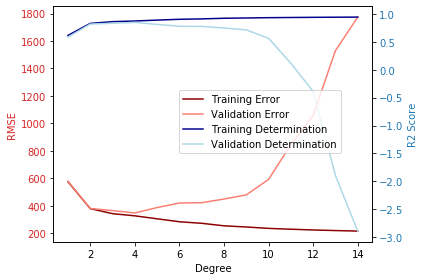

380.84066901315106 0.8198531433016966


In [291]:
mpd = r2_val_lst.index(max(r2_val_lst))+1 #most performant degree
best_model = model_lst[(mpd-1)]

print("Best performance for model of degree " + str(mpd) + " with performance of R2-Score " + str(r2_val_lst[(mpd-1)]))

#Performance of polynomial model
df_ppm = pd.DataFrame(list(zip(degr, rmse_train_lst, rmse_val_lst, r2_train_lst, r2_val_lst)), 
               columns =['Degree', 'Training Error', 'Validation Error', 'Training Determination', 'Validation Determination'])


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Degree')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(df_ppm['Degree'],df_ppm['Training Error'], color='darkred', label= 'Training Error')
ax1.plot(df_ppm['Degree'],df_ppm['Validation Error'], color='salmon',label = 'Validation Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(df_ppm['Degree'], df_ppm['Training Determination'], color='darkblue', label = 'Training Determination')
ax2.plot(df_ppm['Degree'], df_ppm['Validation Determination'], color='lightblue', label = 'Validation Determination')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='center right', bbox_to_anchor=(0,0,0.8,1.1)) #position legend so that graph & axes is visible
plt.show()

# evaluating on test
x_test_array = np.array(x_test24)
poly = PolynomialFeatures(degree = mpd, include_bias=False)
poly_xtest = poly.fit_transform(x_test_array)

best_prediction = best_model.predict(poly_xtest)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test24, best_prediction))
r2_test = metrics.r2_score(y_test24, best_prediction)

print(rmse_test, r2_test)